# IDS Hybrid Pipeline — v5 (Colab)

**Datasets**: KDD‑CUP99 (binary/multiclass), CIC‑IDS2017 (binary/multiclass), CIC‑MalMem‑2022 (binary)

Incluye:
- Montaje de Google Drive y **salida en** `Mi unidad/Colab Notebooks/ids_pipeline/<DATASET_MODE>/`.
- Lectura directa desde tus rutas (`Datasets/...`).
- **Selección de modelos a ejecutar** (ML/DL por listas).
- **SMOTE antes y después** (gráfico de distribución por clase / barras).
- **XGBoost** para importancia y **selección de top‑k**; tabla y gráfico Top‑20.
- **Métricas** (Accuracy, Precision, Recall, F1, AUC), **Matriz de confusión**, **Curvas ROC**.
- **Checkpoints**: ML (`.joblib`) y DL (`.keras`), reanudables.
- **Mixed precision** + *batch size* dinámico en GPU (T4/L4/A100).

Metodología alineada con tu pipeline inicial y con Talukder et al. (2023).


## 0) Entorno: Montar Drive y rutas

In [15]:
# 0) Entorno: detectar Colab, montar Drive y definir rutas base
import os

IN_COLAB = False
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    OUT_ROOT = '/content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote'
    DATA_ROOT = '/content/drive/MyDrive/Colab Notebooks/Datasets'
    print("✅ Drive montado en /content/drive")
else:
    OUT_ROOT = os.path.abspath('./ids_pipeline')
    DATA_ROOT = os.path.abspath('./Datasets')
    print("⚠️ No estás en Colab; usando rutas locales.")

for p in (OUT_ROOT, DATA_ROOT):
    os.makedirs(p, exist_ok=True)

print("📁 OUT_ROOT:", OUT_ROOT)
print("📁 DATA_ROOT:", DATA_ROOT)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Drive montado en /content/drive
📁 OUT_ROOT: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote
📁 DATA_ROOT: /content/drive/MyDrive/Colab Notebooks/Datasets


## 1) Setup automático



In [ ]:
%%bash
python -V
echo "🔧 Limpiando dependencias conflictivas de Colab…"

# 0) Desinstalar paquetes que chocan con nuestro stack
python -m pip -q uninstall -y \
  jax jaxlib flax optax orbax-checkpoint \
  tensorflow-text tensorflow-decision-forests tf-keras tensorstore pytensor || true

# 1) Actualizar herramientas base
python -m pip -q install --upgrade pip setuptools wheel

echo "📦 Instalando stack base (TF 2.18 + NumPy 1.26.x)…"
python -m pip -q install --no-cache-dir \
  "tensorflow==2.18.0" "keras==3.6.0" \
  "numpy==1.26.4" "pandas==2.2.2" "matplotlib==3.8.4" "seaborn==0.13.2"

echo "📦 Instalando librerías de ML…"
python -m pip -q install --no-cache-dir \
  "scikit-learn==1.5.2" "imbalanced-learn==0.12.3" \
  "xgboost==2.1.1" "lightgbm==4.3.0" "catboost==1.2.5"

# 2) Reparar ml_dtypes para que JAX no moleste
echo "🔧 Corrigiendo ml_dtypes…"
python -m pip -q install --no-cache-dir "ml_dtypes==0.5.0"

echo "✅ Setup de dependencias v4.3.1 completado."


In [17]:
import sys, numpy as np, tensorflow as tf, sklearn
import xgboost, lightgbm, catboost

print("Python :", sys.version)
print("NumPy  :", np.__version__)
print("TF     :", tf.__version__)
print("SKL    :", sklearn.__version__)
print("XGB    :", xgboost.__version__)
print("LGBM   :", lightgbm.__version__)
print("CatB   :", catboost.__version__)
print("✅ Entorno de dependencias listo.")


Python : 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
NumPy  : 1.26.4
TF     : 2.18.0
SKL    : 1.5.2
XGB    : 2.1.1
LGBM   : 4.3.0
CatB   : 1.2.5
✅ Entorno de dependencias listo.


## 2) Configuración: Dataset, modo y selección de modelos

In [18]:
# 2) Configuración del experimento (dataset, modo, modelos, rutas)

import os

# DATASET: 'KDD', 'CICIDS2017', 'MalMem2022'
DATASET = 'CICIDS2017'          # <-- cámbialo a 'CICIDS2017' o 'MalMem2022'
TASK_MODE = 'multiclass'     # 'binary' o 'multiclass' (MalMem2022 solo 'binary')

# Qué tipo de modelos ejecutar
RUN_ML = True
RUN_DL = True

# 🔧 Modo de SMOTE:
#   "dynamic" -> SMOTE Inteligente (actual)
#   "full"    -> SMOTE completo estilo paper (todas las clases hacia la mayoritaria)
#   "none"    -> sin SMOTE
SMOTE_MODE = "full"   # "dynamic" o "full" o "none"

# Modelos de Machine Learning
ML_TO_RUN = ['RF'] # ['RF', 'DT', 'KNN', 'MLP', 'LightGBM', 'CatBoost']

# Modelos de Deep Learning
DL_TO_RUN = []  # ['ANN', 'CNN1D', 'LSTM', 'AE_LR'] Autoencoder + Logistic Regression

# Rutas de datasets en tu Drive (como me los pasaste)
KDD_FILE    = f"{DATA_ROOT}/KDD-CUP99/kddcup.data_10_percent.csv"
CIC_DIR     = f"{DATA_ROOT}/CIC-IDS2017"
MALMEM_FILE = f"{DATA_ROOT}/MalMem2022/MalMem2022.csv"

# Nombre de etiqueta esperado por dataset
LABEL_COLS = {
    'KDD': 'label',
    'CICIDS2017': 'Label',
    'MalMem2022': 'Class',
}

LABEL_COL = LABEL_COLS[DATASET]

# Identificador de corrida
RUN_TAG = f"{DATASET}_{TASK_MODE}"

# Carpetas de salida
RUN_DIR = os.path.join(OUT_ROOT, RUN_TAG)
FIG_DIR = os.path.join(RUN_DIR, "figs")
REP_DIR = os.path.join(RUN_DIR, "reports")
CKPT_DIR = os.path.join(RUN_DIR, "checkpoints")

for d in (RUN_DIR, FIG_DIR, REP_DIR, CKPT_DIR):
    os.makedirs(d, exist_ok=True)

print(f"🎯 DATASET: {DATASET}")
print(f"🎯 TASK_MODE: {TASK_MODE}")
print(f"⚙️ SMOTE_MODE = {SMOTE_MODE}")
print(f"📂 RUN_DIR: {RUN_DIR}")
print(f"📂 FIG_DIR: {FIG_DIR}")
print(f"📂 REP_DIR: {REP_DIR}")
print(f"📂 CKPT_DIR: {CKPT_DIR}")

🎯 DATASET: CICIDS2017
🎯 TASK_MODE: multiclass
⚙️ SMOTE_MODE = full
📂 RUN_DIR: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/CICIDS2017_multiclass
📂 FIG_DIR: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/CICIDS2017_multiclass/figs
📂 REP_DIR: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/CICIDS2017_multiclass/reports
📂 CKPT_DIR: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/CICIDS2017_multiclass/checkpoints


## 3) Utilidades (guardado, plots, reporte)

In [19]:
# 3) Utilidades (guardado, plots, reporte, logging) — v4.3.1

import gc, time, json, numpy as np, pandas as pd, os, datetime
from pathlib import Path
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, confusion_matrix,
    roc_auc_score, roc_curve, auc
)
from contextlib import contextmanager

LOG_PATH = os.path.join(RUN_DIR, "log.txt")

def _append_log(msg: str):
    ts = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    line = f"[{ts}] {msg}"
    print(msg)
    os.makedirs(os.path.dirname(LOG_PATH), exist_ok=True)
    with open(LOG_PATH, "a", encoding="utf-8") as f:
        f.write(line + "\n")

@contextmanager
def timed_block(name: str):
    _append_log(f"▶️ Inicio bloque {name}")
    t0 = time.time()
    try:
        yield
    finally:
        dt = time.time() - t0
        _append_log(f"⏱ Fin bloque {name} (duración: {dt:.2f} s)")

def save_json(obj, path):
    with open(path, 'w', encoding="utf-8") as f:
        json.dump(obj, f, indent=2)

def load_json(path):
    with open(path, 'r', encoding="utf-8") as f:
        return json.load(f)

def show_and_save_current_fig(fig_path, dpi=150):
    os.makedirs(os.path.dirname(fig_path), exist_ok=True)
    plt.tight_layout()
    plt.savefig(fig_path, dpi=dpi, bbox_inches='tight')
    plt.show()
    _append_log(f"📊 Gráfico guardado en: {fig_path}")

def save_and_display_table(df, path, note=None):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    df.to_csv(path, index=False)
    display(df)
    msg = f"📄 Tabla guardada en: {path}"
    if note:
        msg += f" — {note}"
    _append_log(msg)

def free_mem(*vs):
    for v in vs:
        try:
            del v
        except Exception:
            pass
    gc.collect()

CKPT_META = os.path.join(CKPT_DIR, 'meta.json')
if not os.path.exists(CKPT_META):
    save_json({'models': {}}, CKPT_META)

def record_model(name, path):
    meta = load_json(CKPT_META)
    meta['models'][name] = path
    save_json(meta, CKPT_META)

REPORT_PATH = os.path.join(REP_DIR, f'summary_{RUN_TAG}.json')
if not os.path.exists(REPORT_PATH):
    save_json({'run': RUN_TAG, 'results': []}, REPORT_PATH)

def log_result(entry):
    rep = load_json(REPORT_PATH)
    rep['results'].append(entry)
    save_json(rep, REPORT_PATH)

_append_log("✅ Utilidades cargadas.")


✅ Utilidades cargadas.


## 4) Carga de datos (por dataset) + limpieza básica

In [20]:
# 4) Carga de datos por dataset + verificación de LABEL_COL

import pandas as pd, glob

def _standardize_columns(df):
    df.columns = (
        df.columns.astype(str)
        .str.replace('\ufeff', '', regex=False)
        .str.strip()
        .str.replace(r'\s+', ' ', regex=True)
    )
    return df

def load_kdd(path: str) -> pd.DataFrame:
    _append_log(f"📥 Cargando KDD desde: {path}")
    df = pd.read_csv(path, header=None, low_memory=False)
    df.columns = [*(f"f{i}" for i in range(df.shape[1]-1)), "label"]
    return _standardize_columns(df)

def concat_cic(dir_like: str, chunksize: int = 200_000) -> pd.DataFrame:
    _append_log(f"📥 Concatenando archivos CIC-IDS2017 desde: {dir_like}")
    order = [
        "Monday-WorkingHours.pcap_ISCX.csv","Tuesday-WorkingHours.pcap_ISCX.csv",
        "Wednesday-workingHours.pcap_ISCX.csv","Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
        "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv","Friday-WorkingHours-Morning.pcap_ISCX.csv",
        "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv","Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv",
    ]
    files = [os.path.join(dir_like, f) for f in order if os.path.exists(os.path.join(dir_like, f))]
    if not files:
        files = sorted(glob.glob(os.path.join(dir_like, "*.csv")))
    if not files:
        raise FileNotFoundError("No se encontraron CSV en la carpeta CIC-IDS2017")
    dfs = []
    for f in files:
        _append_log(f"  ├─ {os.path.basename(f)}")
        for ch in pd.read_csv(f, chunksize=chunksize, low_memory=False):
            dfs.append(_standardize_columns(ch))
    return _standardize_columns(pd.concat(dfs, ignore_index=True))

def _detect_label_col(df: pd.DataFrame, expected: str) -> str:
    if expected in df.columns:
        return expected
    for c in df.columns:
        if c.strip().casefold() in {"label", "class"}:
            return c
    raise KeyError(f"No se encontró columna de etiqueta. Columnas: {list(df.columns)[:20]}")

def normalize_cic_labels(df: pd.DataFrame, label_col: str) -> pd.DataFrame:
    df[label_col] = df[label_col].astype(str).str.strip()
    mapping = {
        "Web Attack - Brute Force": "Web Attack – Brute Force",
        "Web Attack - XSS": "Web Attack – XSS",
        "Web Attack - Sql Injection": "Web Attack – Sql Injection",
        "BENIGN ": "BENIGN",
    }
    df[label_col] = df[label_col].map(lambda x: mapping.get(x, x))
    return df

with timed_block("4 - Carga de datos"):
    if DATASET == "KDD":
        assert os.path.exists(KDD_FILE), "Sube kddcup.data_10_percent.csv a la ruta indicada"
        df_raw = load_kdd(KDD_FILE)
        LABEL_COL = "label"
    elif DATASET == "CICIDS2017":
        df_raw = concat_cic(CIC_DIR, chunksize=200_000)
        LABEL_COL = _detect_label_col(df_raw, LABEL_COLS["CICIDS2017"])
        df_raw = normalize_cic_labels(df_raw, LABEL_COL)
    else:  # MalMem2022
        assert os.path.exists(MALMEM_FILE), "Sube MalMem2022.csv a la ruta indicada"
        _append_log(f"📥 Cargando MalMem2022 desde: {MALMEM_FILE}")
        df_raw = pd.read_csv(MALMEM_FILE, low_memory=False)
        df_raw = _standardize_columns(df_raw)
        LABEL_COL = _detect_label_col(df_raw, LABEL_COLS["MalMem2022"])

    print("📐 df_raw shape:", df_raw.shape)
    display(df_raw.head())

    # Verificación de columna de etiqueta
    print(f"📋 Columnas totales: {len(df_raw.columns)}")
    print(f"🎯 Columna de etiqueta esperada/detectada: '{LABEL_COL}'")

    if LABEL_COL not in df_raw.columns:
        print("⚠️ No se encontró la columna esperada. Últimas 10 columnas:")
        print(list(df_raw.columns[-10:]))
    else:
        print("✅ Columna de etiqueta encontrada.")
        uniques = pd.Series(df_raw[LABEL_COL].astype(str).unique())
        print("Ejemplos de valores:", list(uniques[:10]))
        print("📦 Conteo (primeros 20):")
        display(df_raw[LABEL_COL].value_counts().head(20))


▶️ Inicio bloque 4 - Carga de datos
📥 Concatenando archivos CIC-IDS2017 desde: /content/drive/MyDrive/Colab Notebooks/Datasets/CIC-IDS2017
  ├─ Monday-WorkingHours.pcap_ISCX.csv
  ├─ Tuesday-WorkingHours.pcap_ISCX.csv
  ├─ Wednesday-workingHours.pcap_ISCX.csv
  ├─ Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
  ├─ Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
  ├─ Friday-WorkingHours-Morning.pcap_ISCX.csv
  ├─ Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
  ├─ Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
📐 df_raw shape: (2830743, 79)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,49188,4,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,3000000.0,5.000000e+05,4.0,0.0,4,4,4,4.0,0.0,4,4,0,0.0,0.0,0,0,0,0,0,0,40,0,5.000000e+05,0.0,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,329,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,49188,1,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,12000000.0,2.000000e+06,1.0,0.0,1,1,1,1.0,0.0,1,1,0,0.0,0.0,0,0,0,0,0,0,40,0,2.000000e+06,0.0,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,329,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,49188,1,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,12000000.0,2.000000e+06,1.0,0.0,1,1,1,1.0,0.0,1,1,0,0.0,0.0,0,0,0,0,0,0,40,0,2.000000e+06,0.0,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,329,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,49188,1,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,12000000.0,2.000000e+06,1.0,0.0,1,1,1,1.0,0.0,1,1,0,0.0,0.0,0,0,0,0,0,0,40,0,2.000000e+06,0.0,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,329,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,49486,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4000000.0,6.666667e+05,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,6.666667e+05,0.0,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,245,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


📋 Columnas totales: 79
🎯 Columna de etiqueta esperada/detectada: 'Label'
✅ Columna de etiqueta encontrada.
Ejemplos de valores: ['BENIGN', 'FTP-Patator', 'SSH-Patator', 'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye', 'Heartbleed', 'Web Attack � Brute Force', 'Web Attack � XSS']
📦 Conteo (primeros 20):


,count
Label,
BENIGN,2273097
DoS Hulk,231073
PortScan,158930
DDoS,128027
DoS GoldenEye,10293
FTP-Patator,7938
SSH-Patator,5897
DoS slowloris,5796
DoS Slowhttptest,5499


⏱ Fin bloque 4 - Carga de datos (duración: 35.92 s)


## 5) Preparación, codificación, split + **distribución por clase** (antes de SMOTE)

▶️ Inicio bloque 5 - Preprocesamiento y distribución inicial (Before SMOTE)
🔄 Iniciando preprocesamiento…
🧮 CICIDS2017: filas antes del mapeo AttackType=2830743, después=2830743
🪪 CICIDS2017 multiclase (grupos agregados): ['BENIGN', 'Bot', 'Brute Force', 'DDoS', 'DoS', 'Heartbleed', 'Infiltration', 'Port Scan', 'Web Attack']
📦 Distribución de AttackType (CIC, grupos):


,count
AttackType,
BENIGN,2273097
DoS,252661
Port Scan,158930
DDoS,128027
Brute Force,13835
Web Attack,2180
Bot,1966
Infiltration,36
Heartbleed,11


📐 X shape: (2830743, 78), y shape: (2830743,)
⏱ Fin bloque 5 - Preprocesamiento y distribución inicial (Before SMOTE) (duración: 6.60 s)


,Class,Count
0,BENIGN,2273097
1,Bot,1966
2,Brute Force,13835
3,DDoS,128027
4,DoS,252661
5,Heartbleed,11
6,Infiltration,36
7,Port Scan,158930
8,Web Attack,2180


📄 Tabla guardada en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/CICIDS2017_multiclass/reports/class_dist_before_CICIDS2017_multiclass.csv — Distribución de clases antes de SMOTE


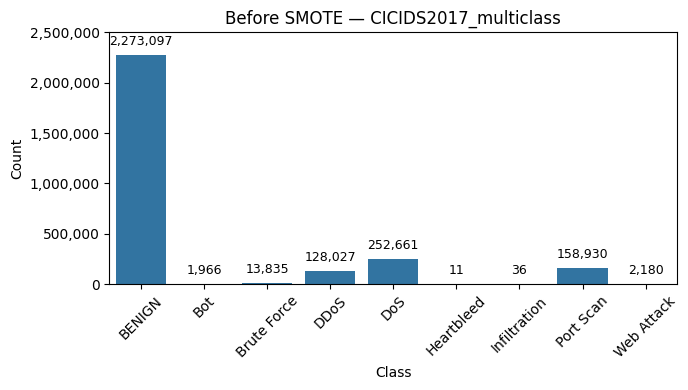

📊 Gráfico guardado en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/CICIDS2017_multiclass/figs/class_dist_before_smote_CICIDS2017_multiclass.png
✅ Bloque 5 completado (Before SMOTE).


In [21]:
## 5) Preparación y distribución **antes de SMOTE** — v4.3.4

from sklearn.preprocessing import LabelEncoder
from matplotlib.ticker import MaxNLocator, StrMethodFormatter

with timed_block("5 - Preprocesamiento y distribución inicial (Before SMOTE)"):
    _append_log("🔄 Iniciando preprocesamiento…")

    df = df_raw.copy()

    # 1) Definir target según DATASET y TASK_MODE
    if DATASET == 'CICIDS2017':
        # Normalizar etiqueta original
        df[LABEL_COL] = df[LABEL_COL].astype(str).str.strip()

        # === AGRUPACIÓN OFICIAL CIC-IDS2017: 15 etiquetas → 9 tipos de ataque ===
        attack_map_cic = {
            'BENIGN': 'BENIGN',
            'DDoS': 'DDoS',
            'DoS Hulk': 'DoS',
            'DoS GoldenEye': 'DoS',
            'DoS slowloris': 'DoS',
            'DoS Slowhttptest': 'DoS',
            'PortScan': 'Port Scan',
            'FTP-Patator': 'Brute Force',
            'SSH-Patator': 'Brute Force',
            'Bot': 'Bot',
            'Web Attack � Brute Force': 'Web Attack',
            'Web Attack � XSS': 'Web Attack',
            'Web Attack � Sql Injection': 'Web Attack',
            'Web Attack – Brute Force': 'Web Attack',
            'Web Attack – XSS': 'Web Attack',
            'Web Attack – Sql Injection': 'Web Attack',
            'Web Attack - Brute Force': 'Web Attack',
            'Web Attack - XSS': 'Web Attack',
            'Web Attack - Sql Injection': 'Web Attack',
            'Infiltration': 'Infiltration',
            'Heartbleed': 'Heartbleed'
        }

        df["AttackType"] = df[LABEL_COL].map(attack_map_cic)

        before_rows = len(df)
        df = df[~df["AttackType"].isna()].copy()
        after_rows = len(df)
        _append_log(f"🧮 CICIDS2017: filas antes del mapeo AttackType={before_rows}, después={after_rows}")

        if TASK_MODE == 'binary':
            df['target'] = (df["AttackType"] != "BENIGN").astype(int)
            class_names = ['BENIGN', 'ATTACK']
            label_map = {0: 'BENIGN', 1: 'ATTACK'}
            _append_log("🪪 CICIDS2017 (binaria) usando AttackType (BENIGN vs ATTACK).")
        else:
            le = LabelEncoder()
            df['target'] = le.fit_transform(df["AttackType"])
            class_names = list(le.classes_)
            label_map = {i: c for i, c in enumerate(class_names)}
            _append_log(f"🪪 CICIDS2017 multiclase (grupos agregados): {class_names}")
            _append_log("📦 Distribución de AttackType (CIC, grupos):")
            display(df["AttackType"].value_counts())

    elif DATASET == 'KDD':
        # -------------------------------------------
        # 0) Asignar nombres reales a las features KDD
        # -------------------------------------------
        _append_log("🔧 KDD: asignando nombres reales de features KDD CUP'99…")

        kdd_feature_names = [
            'duration', 'protocol_type', 'service', 'flag',
            'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent',
            'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
            'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
            'num_shells', 'num_access_files', 'num_outbound_cmds',
            'is_host_login', 'is_guest_login', 'count', 'srv_count',
            'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
            'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
            'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
            'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
            'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
            'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
            'dst_host_srv_rerror_rate'
        ]

        # Columnas que actualmente son features (ej. f0..f40) = todas menos LABEL_COL
        feature_cols_raw = [c for c in df.columns if c != LABEL_COL]

        if len(feature_cols_raw) != 41:
            _append_log(
                f"⚠️ Advertencia KDD: se esperaban 41 columnas de features y se encontraron {len(feature_cols_raw)}. "
                "Se intentará renombrar parcialmente (zip corto)."
            )

        # Mapear nombres originales (f0,f1,...) → nombres reales de KDD
        col_map = dict(zip(feature_cols_raw, kdd_feature_names))
        df.rename(columns=col_map, inplace=True)

        _append_log("✅ Nombres reales asignados a las columnas de features KDD.")
        _append_log(f"🔎 Primeras columnas KDD: {df.columns.tolist()[:10]}")

        # -------------------------------------------
        # 1) Normalizar etiquetas de KDD (label)
        # -------------------------------------------
        df[LABEL_COL] = (
            df[LABEL_COL]
            .astype(str)
            .str.strip()
            .str.lower()
            .str.rstrip('.')        # <--- quita el "." final si lo hay
        )

        _append_log("🔎 Ejemplos de etiquetas crudas (KDD) tras limpieza:")
        display(df[LABEL_COL].value_counts().head(15))

        # -------------------------------------------
        # 2) Conversión numérica unificada de features
        # -------------------------------------------
        _append_log("🔧 KDD: convirtiendo todas las features a numérico (errors='coerce')…")
        df[LABEL_COL] = df[LABEL_COL].astype(str)

        feat_cols_kdd = [c for c in df.columns if c != LABEL_COL]
        df[feat_cols_kdd] = df[feat_cols_kdd].apply(pd.to_numeric, errors="coerce")
        df[feat_cols_kdd] = df[feat_cols_kdd].fillna(0)

        _append_log("✅ Conversión numérica KDD completada (ejemplo dtypes):")
        display(df[feat_cols_kdd].dtypes.head())

        if TASK_MODE == 'binary':
            # normal vs cualquier otro ataque
            df['target'] = (df[LABEL_COL] != 'normal').astype(int)
            class_names = ['normal', 'attack']
            label_map = {0: 'normal', 1: 'attack'}
            _append_log("🪪 KDD (binaria): normal vs attack (labels normal / !=normal).")

        else:
            # --- Mapeo a 5 superclases: DoS, Normal, Probe, R2L, U2R ---
            kdd_attack_map_clean = {
                # Normal
                'normal': 'Normal',

                # DoS
                'back': 'DoS',
                'land': 'DoS',
                'neptune': 'DoS',
                'pod': 'DoS',
                'smurf': 'DoS',
                'teardrop': 'DoS',
                'apache2': 'DoS',
                'mailbomb': 'DoS',
                'processtable': 'DoS',
                'udpstorm': 'DoS',

                # Probe
                'ipsweep': 'Probe',
                'nmap': 'Probe',
                'portsweep': 'Probe',
                'satan': 'Probe',
                'mscan': 'Probe',
                'saint': 'Probe',

                # R2L
                'ftp_write': 'R2L',
                'guess_passwd': 'R2L',
                'http_tunnel': 'R2L',
                'imap': 'R2L',
                'multihop': 'R2L',
                'named': 'R2L',
                'phf': 'R2L',
                'sendmail': 'R2L',
                'snmpgetattack': 'R2L',
                'snmpguess': 'R2L',
                'spy': 'R2L',
                'warezclient': 'R2L',
                'warezmaster': 'R2L',

                # U2R
                'buffer_overflow': 'U2R',
                'loadmodule': 'U2R',
                'perl': 'U2R',
                'rootkit': 'U2R',
                'ps': 'U2R',
                'xterm': 'U2R',
                'sqlattack': 'U2R'
            }

            df['AttackType'] = df[LABEL_COL].map(kdd_attack_map_clean)

            before_rows = len(df)
            df = df[~df['AttackType'].isna()].copy()
            after_rows = len(df)
            _append_log(
                f"🧮 KDD multiclase: filas antes del mapeo={before_rows}, después={after_rows}"
            )

            if after_rows == 0:
                raise ValueError(
                    "❌ Ninguna etiqueta de KDD pudo mapearse a AttackType.\n"
                    "Revisa los valores únicos de la columna de etiqueta que se mostraron arriba."
                )

            # Orden de clases EXACTAMENTE como en el paper
            class_order = ['DoS', 'Normal', 'Probe', 'R2L', 'U2R']
            class_to_id = {c: i for i, c in enumerate(class_order)}  # DoS->0, Normal->1,...

            df['target'] = df['AttackType'].map(class_to_id).astype(int)

            class_names = class_order
            label_map   = {i: c for i, c in enumerate(class_order)}

            _append_log(
                f"🪪 KDD (multiclase): AttackType → {class_order} con codificación 0–4 según el paper."
            )
            _append_log("📦 Distribución de AttackType (KDD, 5 clases):")
            display(df['AttackType'].value_counts())

    else:  # MalMem2022 (binario)
        if df[LABEL_COL].dtype == 'object':
            df[LABEL_COL] = df[LABEL_COL].astype(str).str.strip().str.lower()
            df['target'] = (df[LABEL_COL] != 'benign').astype(int)
        else:
            df['target'] = df[LABEL_COL].astype(int)
        class_names = ['Benign', 'Malware']
        label_map = {0: 'Benign', 1: 'Malware'}
        _append_log("🪪 MalMem2022 (binaria): Benign vs Malware.")

    # 2) Construir X numérico e y
    y = df['target'].astype(int).values
    X = (
        df.drop(columns=['target', LABEL_COL, 'AttackType'], errors='ignore')
          .select_dtypes(include=['number'])
          .astype('float32')
    )

    if X.shape[1] == 0:
        raise ValueError(
            "❌ X tiene 0 columnas (ninguna feature numérica). "
            "Revisa el mapeo y conversión de features en el bloque 5."
        )

    _append_log(f"📐 X shape: {X.shape}, y shape: {y.shape}")

# 3) Distribución de clases ANTES de SMOTE (tabla + gráfico)

counts_before = pd.Series(y).value_counts().sort_index()
counts_before_named = counts_before.rename(index=label_map).reset_index()
counts_before_named.columns = ['Class', 'Count']

before_csv = os.path.join(REP_DIR, f'class_dist_before_{RUN_TAG}.csv')
save_and_display_table(
    counts_before_named,
    before_csv,
    note="Distribución de clases antes de SMOTE"
)

plt.figure(figsize=(7, 4))
ax = sns.barplot(x=counts_before_named['Class'],
                 y=counts_before_named['Count'])

# --- ANOTACIÓN Y PADDING EN Y (como acordamos) ---
max_height = 0  # Para guardar la barra más alta
for p in ax.patches:
    height = p.get_height()
    if height > max_height:
        max_height = height

    ax.annotate(
        f"{int(height):,}",
        (p.get_x() + p.get_width() / 2., height),
        ha='center', va='bottom', fontsize=9,
        xytext=(0, 5), textcoords='offset points'
    )

ax.set_title(f"Before SMOTE — {RUN_TAG}")
ax.set_xlabel("Class")
ax.set_ylabel("Count")

ax.yaxis.set_major_locator(MaxNLocator(nbins=6, integer=True))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.set_ylim(top=max_height * 1.1 if max_height > 0 else 1)

plt.xticks(rotation=45)
fig_path_before = os.path.join(FIG_DIR, f'class_dist_before_smote_{RUN_TAG}.png')
show_and_save_current_fig(fig_path_before)

_append_log("✅ Bloque 5 completado (Before SMOTE).")

## 6) Train/Test split, escalado y **SMOTE** (con gráfico **después**)

▶️ Inicio bloque 6 - Train/Test split, escalado y SMOTE (v6.1)
🔎 Bloque 6 (v6.1): X=(2830743, 78), y=2830743, n_classes=9, SMOTE_MODE=full
🪪 class_names usados en Bloque 6: ['BENIGN', 'Bot', 'Brute Force', 'DDoS', 'DoS', 'Heartbleed', 'Infiltration', 'Port Scan', 'Web Attack']
🧬 Modo SMOTE_FULL: SMOTE al dataset completo (estilo paper).
📏 Escalado global con StandardScaler(with_mean=False).


,Class,Count Before
0,BENIGN,2273097
1,Bot,1966
2,Brute Force,13835
3,DDoS,128027
4,DoS,252661
5,Heartbleed,11
6,Infiltration,36
7,Port Scan,158930
8,Web Attack,2180


📄 Tabla guardada en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/CICIDS2017_multiclass/reports/CICIDS2017_multiclass_class_dist_before_only_FULL.csv — Before SMOTE (dataset completo, modo FULL).
📄 BEFORE SMOTE (FULL) CSV --> /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/CICIDS2017_multiclass/reports/CICIDS2017_multiclass_class_dist_before_only_FULL.csv
🧪 SMOTE FULL sampling_strategy={1: 2273097, 2: 2273097, 3: 2273097, 4: 2273097, 5: 2273097, 6: 2273097, 7: 2273097, 8: 2273097}, k=5, max_count=2273097


/usr/local/lib/python3.12/dist-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


,Class,Count_Before,Count_After,Diff
0,BENIGN,2273097,2273097,0
1,Bot,1966,2273097,2271131
2,Brute Force,13835,2273097,2259262
3,DDoS,128027,2273097,2145070
4,DoS,252661,2273097,2020436
5,Heartbleed,11,2273097,2273086
6,Infiltration,36,2273097,2273061
7,Port Scan,158930,2273097,2114167
8,Web Attack,2180,2273097,2270917


📄 Tabla guardada en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/CICIDS2017_multiclass/reports/CICIDS2017_multiclass_class_dist_before_after_smote_FULL.csv — Before & After SMOTE FULL (dataset completo).
📄 BEFORE/AFTER (FULL) CSV --> /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/CICIDS2017_multiclass/reports/CICIDS2017_multiclass_class_dist_before_after_smote_FULL.csv


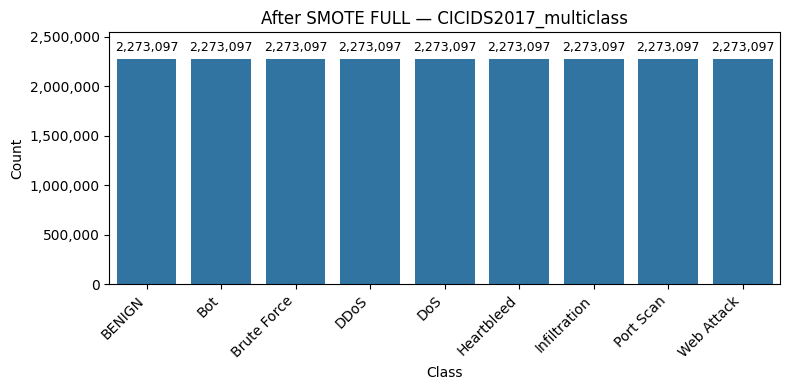

📊 Gráfico guardado en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/CICIDS2017_multiclass/figs/class_dist_after_only_smote_FULL_CICIDS2017_multiclass.png
🖼 AFTER SMOTE FULL FIG --> /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/CICIDS2017_multiclass/figs/class_dist_after_only_smote_FULL_CICIDS2017_multiclass.png
✂️ Split (FULL-SMOTE): X_train=(16366298, 78), X_test=(4091575, 78), y_train=16366298, y_test=4091575


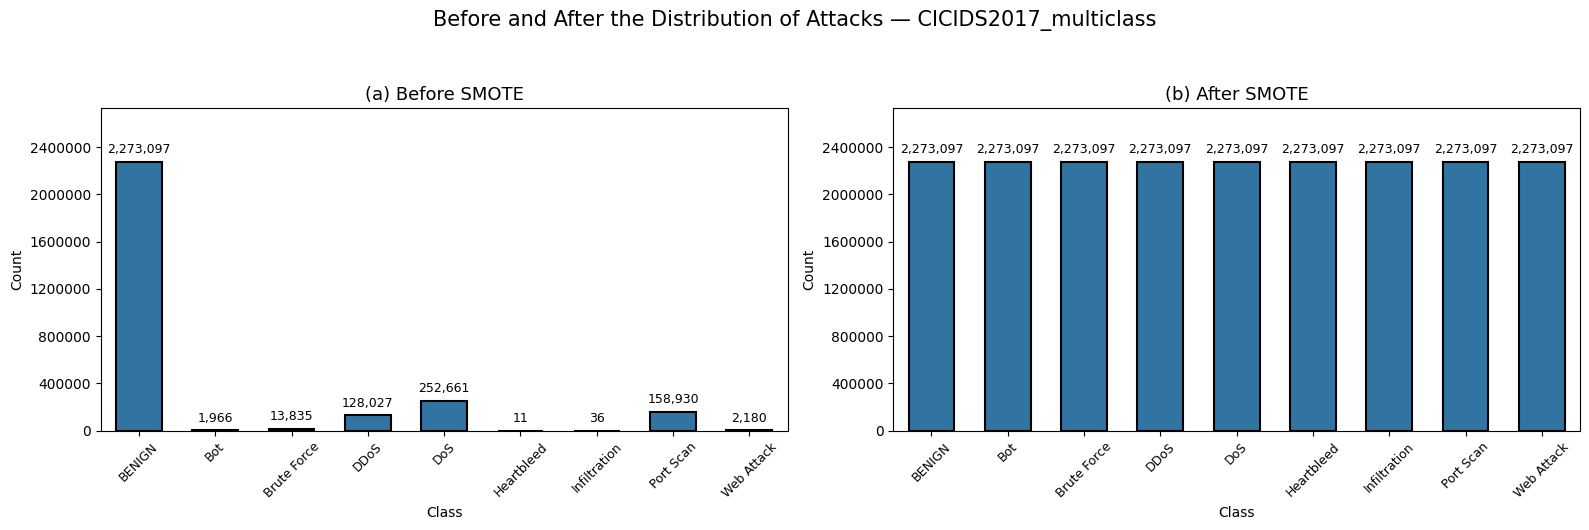

📊 Gráfico guardado en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/CICIDS2017_multiclass/figs/class_dist_before_after_smote_CICIDS2017_multiclass.png


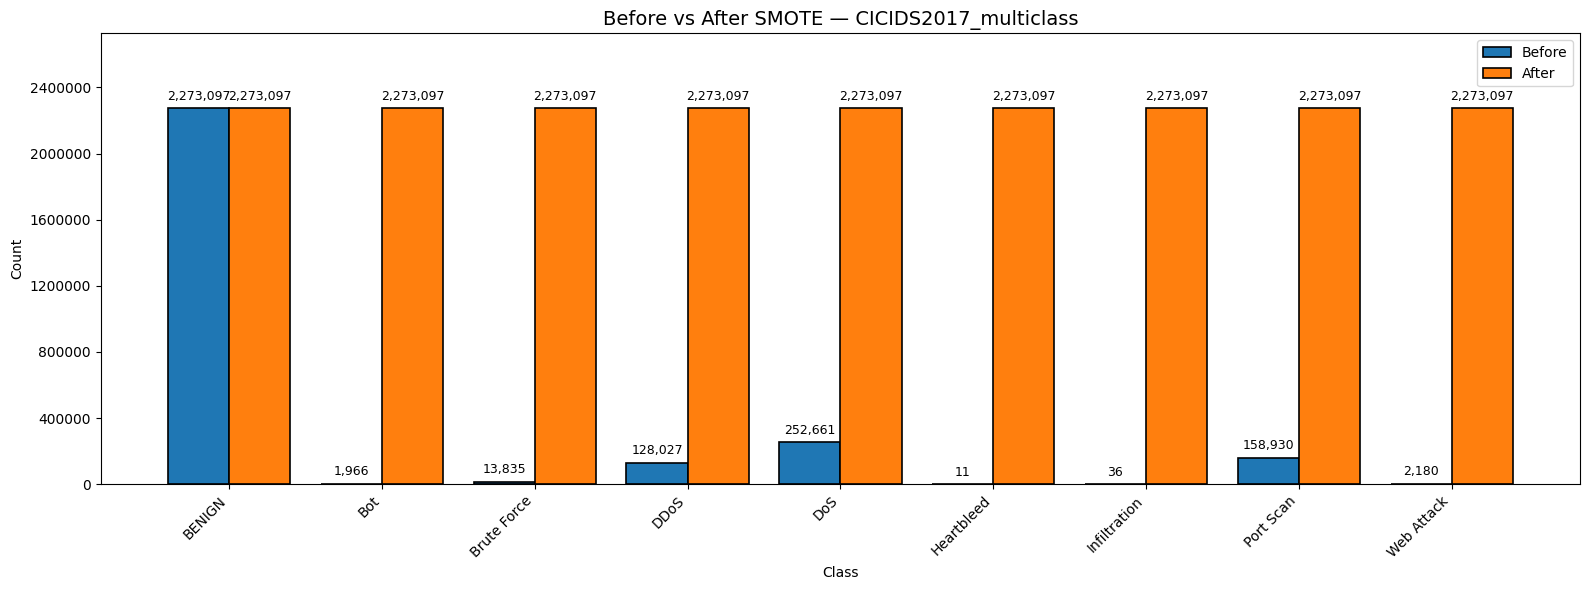

📊 Gráfico guardado en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/CICIDS2017_multiclass/figs/class_dist_before_vs_after_smote_CICIDS2017_multiclass.png
🖼 BEFORE vs AFTER FIG --> /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/CICIDS2017_multiclass/figs/class_dist_before_vs_after_smote_CICIDS2017_multiclass.png
✅ Bloque 6 completado (v6.1). X_train=(16366298, 78), X_test=(4091575, 78), y_train=16366298, y_test=4091575, SMOTE_MODE=full.
✅ BLOQUE 6 OK — modo: full
⏱ Fin bloque 6 - Train/Test split, escalado y SMOTE (v6.1) (duración: 302.39 s)


In [22]:
## ============================================================
## 6) Train/Test split, escalado y SMOTE (full / dynamic / none) — v6.1
## ============================================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from matplotlib.ticker import MaxNLocator, StrMethodFormatter

with timed_block("6 - Train/Test split, escalado y SMOTE (v6.1)"):

    # ----------------------------------------------------------
    # 0) Validaciones previas
    # ----------------------------------------------------------
    if 'X' not in locals() or 'y' not in locals():
        raise ValueError("❌ No existen X e y. Ejecuta el BLOQUE 5 antes de este.")

    if 'class_names' not in locals():
        raise ValueError(
            "❌ 'class_names' no existe. Asegúrate de haber ejecutado el BLOQUE 5 "
            "actualizado, donde se define class_names."
        )

    if 'SMOTE_MODE' not in globals():
        SMOTE_MODE = "dynamic"

    if SMOTE_MODE not in ("full", "dynamic", "none"):
        raise ValueError(
            f"❌ SMOTE_MODE='{SMOTE_MODE}' no es válido. Usa 'full', 'dynamic' o 'none'."
        )

    _append_log(
        f"🔎 Bloque 6 (v6.1): X={X.shape}, y={len(y)}, n_classes={len(class_names)}, "
        f"SMOTE_MODE={SMOTE_MODE}"
    )
    print("🪪 class_names usados en Bloque 6:", class_names)

    # Helper: índice → nombre de clase
    def _index_to_label(idx):
        try:
            idx_int = int(idx)
            if 0 <= idx_int < len(class_names):
                return str(class_names[idx_int])
        except Exception:
            pass
        return str(idx)

    # Variables globales que usaremos en otros bloques
    global X_train, X_test, y_train, y_test, X_for_fs, y_for_fs, scaler

    # ----------------------------------------------------------
    # ╔══════════════════════╗
    # ║  MODO 1: SMOTE FULL  ║  (estilo paper)
    # ╚══════════════════════╝
    # ----------------------------------------------------------
    if SMOTE_MODE == "full":
        _append_log("🧬 Modo SMOTE_FULL: SMOTE al dataset completo (estilo paper).")

        # 1) Limpieza global
        X_df = pd.DataFrame(X).replace([np.inf, -np.inf], np.nan).fillna(0)

        # 2) Escalado global
        scaler = StandardScaler(with_mean=False)
        X_scaled = scaler.fit_transform(X_df)
        _append_log("📏 Escalado global con StandardScaler(with_mean=False).")

        # 3) Distribución BEFORE (dataset completo)
        y_series = pd.Series(y)
        counts_before = y_series.value_counts().sort_index()
        idxs = counts_before.index.tolist()
        labels = [_index_to_label(i) for i in idxs]
        counts_before_aligned = counts_before.reindex(idxs).astype(int)

        before_full_df = pd.DataFrame({
            "Class": labels,
            "Count Before": counts_before_aligned.values
        })

        before_csv = os.path.join(REP_DIR, f"{RUN_TAG}_class_dist_before_only_FULL.csv")
        save_and_display_table(
            before_full_df, before_csv,
            note="Before SMOTE (dataset completo, modo FULL)."
        )
        _append_log(f"📄 BEFORE SMOTE (FULL) CSV --> {before_csv}")

        # 4) SMOTE FULL: igualar todas las clases al máx. conteo
        max_count = counts_before.max()
        sampling_strategy = {
            cls_idx: max_count
            for cls_idx, cnt in counts_before.items()
            if cnt < max_count
        }

        if not sampling_strategy:
            _append_log("ℹ️ Todas las clases ya están balanceadas. No se aplica SMOTE FULL.")
            X_bal = X_scaled
            y_bal = y.copy()
        else:
            min_count = counts_before.min()
            k_neighbors = max(1, min(5, min_count - 1))
            _append_log(
                f"🧪 SMOTE FULL sampling_strategy={sampling_strategy}, "
                f"k={k_neighbors}, max_count={max_count}"
            )
            sm = SMOTE(
                random_state=42,
                sampling_strategy=sampling_strategy,
                k_neighbors=k_neighbors,
                n_jobs=-1
            )
            X_bal, y_bal = sm.fit_resample(X_scaled, y)

        # 5) Distribución AFTER (dataset completo balanceado)
        counts_after = pd.Series(y_bal).value_counts().sort_index()
        counts_after = counts_after.reindex(idxs).fillna(0).astype(int)

        comp_full_df = pd.DataFrame({
            "Class": labels,
            "Count_Before": counts_before_aligned.values,
            "Count_After": counts_after.values,
            "Diff": counts_after.values - counts_before_aligned.values
        })

        comp_csv = os.path.join(
            REP_DIR,
            f"{RUN_TAG}_class_dist_before_after_smote_FULL.csv"
        )
        save_and_display_table(
            comp_full_df, comp_csv,
            note="Before & After SMOTE FULL (dataset completo)."
        )
        _append_log(f"📄 BEFORE/AFTER (FULL) CSV --> {comp_csv}")

        # --- Para los gráficos comunes (8 y 9) ---
        dist_wide = comp_full_df.copy()
        n_classes_plot = len(dist_wide["Class"])

        # --- Gráfico SOLO AFTER (FULL) ---
        plt.figure(figsize=(8, 4))
        ax_after = sns.barplot(x="Class", y="Count_After", data=dist_wide)
        max_after = 0
        for p in ax_after.patches:
            h = p.get_height()
            max_after = max(max_after, h)
            if h > 0:
                ax_after.annotate(
                    f"{int(h):,}",
                    (p.get_x() + p.get_width()/2., h),
                    ha='center', va='bottom',
                    fontsize=9,
                    xytext=(0, 4),
                    textcoords='offset points'
                )
        ax_after.set_title(f"After SMOTE FULL — {RUN_TAG}")
        ax_after.set_xlabel("Class")
        ax_after.set_ylabel("Count")
        ax_after.yaxis.set_major_locator(MaxNLocator(nbins=6, integer=True))
        ax_after.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
        ax_after.set_ylim(top=max_after * 1.12 if max_after > 0 else 1)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()

        fig_path_after_full = os.path.join(
            FIG_DIR,
            f"class_dist_after_only_smote_FULL_{RUN_TAG}.png"
        )
        show_and_save_current_fig(fig_path_after_full)
        _append_log(f"🖼 AFTER SMOTE FULL FIG --> {fig_path_after_full}")

        # 6) Split sobre el dataset ya balanceado (estilo paper)
        strat_arg = y_bal if len(set(y_bal)) > 1 else None
        X_train, X_test, y_train, y_test = train_test_split(
            X_bal, y_bal,
            test_size=0.2,
            random_state=42,
            stratify=strat_arg
        )

        # Para Feature Selection (Bloque 7) usamos el train balanceado
        X_for_fs = X_train
        y_for_fs = y_train

        _append_log(
            f"✂️ Split (FULL-SMOTE): X_train={X_train.shape}, X_test={X_test.shape}, "
            f"y_train={len(y_train)}, y_test={len(y_test)}"
        )

    # ----------------------------------------------------------
    # ╔════════════════════════════════════╗
    # ║  MODO 2/3: SMOTE DINÁMICO / NONE  ║
    # ╚════════════════════════════════════╝
    # ----------------------------------------------------------
    else:
        # 1) Split previo (sin SMOTE)
        strat_arg = y if len(set(y)) > 1 else None
        X_train_raw, X_test_raw, y_train_raw, y_test = train_test_split(
            X, y,
            test_size=0.2,
            random_state=42,
            stratify=strat_arg
        )
        _append_log(
            f"✂️ Split: X_train={X_train_raw.shape}, X_test={X_test_raw.shape}, "
            f"y_train={len(y_train_raw)}, y_test={len(y_test)}"
        )

        # 2) Limpieza de inf / NaN → 0
        X_train_df = pd.DataFrame(X_train_raw).replace([np.inf, -np.inf], np.nan).fillna(0)
        X_test_df  = pd.DataFrame(X_test_raw).replace([np.inf, -np.inf], np.nan).fillna(0)
        _append_log("🧹 Limpieza completada (inf → NaN → 0).")

        # 3) Escalado
        scaler = StandardScaler(with_mean=False)
        X_train_scaled = scaler.fit_transform(X_train_df)
        X_test_scaled  = scaler.transform(X_test_df)
        _append_log("📏 Escalado con StandardScaler(with_mean=False).")

        # 4) Distribución BEFORE (train)
        y_train_series = pd.Series(y_train_raw)
        counts_before = y_train_series.value_counts().sort_index()
        class_indices_sorted = counts_before.index.tolist()
        labels_sorted = [_index_to_label(c) for c in class_indices_sorted]
        counts_before_aligned = counts_before.reindex(class_indices_sorted).astype(int)

        print("🔤 Mapeo índice→Clase en Bloque 6 (train):")
        for idx, name in zip(class_indices_sorted, labels_sorted):
            print(f"  {idx} → {name}")

        before_df = pd.DataFrame({
            "Class": labels_sorted,
            "Count Before": counts_before_aligned.values
        })

        before_csv = os.path.join(REP_DIR, f"{RUN_TAG}_class_dist_before_only.csv")
        save_and_display_table(
            before_df, before_csv,
            note="Before SMOTE (train set)."
        )
        _append_log(f"📄 BEFORE SMOTE CSV --> {before_csv}")

        # 5) Según SMOTE_MODE → aplicar o no SMOTE DINÁMICO
        n_classes = len(counts_before)
        min_count = counts_before.min()
        apply_smote = (
            SMOTE_MODE == "dynamic" and
            n_classes > 1 and
            min_count >= 2
        )

        if not apply_smote:
            if SMOTE_MODE == "none":
                _append_log("🚫 Modo NONE: no se aplica SMOTE. Usando train escalado tal cual.")
            else:
                _append_log("⚠️ SMOTE omitido (clases/muestras insuficientes).")
            X_train = X_train_scaled
            y_train = y_train_raw.copy()
            X_test = X_test_scaled
            counts_after = counts_before_aligned.copy()
        else:
            median_count = counts_before.median()
            max_count = counts_before.max()
            base_target = int(min(
                max_count,
                max(5000, int(median_count * 1.5))
            ))
            upper_cap = int(min(max_count, base_target * 3))

            _append_log(
                f"🔧 SMOTE Inteligente: min={min_count}, med={median_count}, max={max_count}, "
                f"base_target={base_target}, upper_cap={upper_cap}"
            )

            sampling_strategy = {}
            for cls_idx, cnt in counts_before.items():
                if cnt < base_target:
                    sampling_strategy[cls_idx] = int(min(base_target, upper_cap))

            if not sampling_strategy:
                _append_log("ℹ️ No hay clases minoritarias. No se aplica SMOTE.")
                X_train = X_train_scaled
                y_train = y_train_raw.copy()
                X_test = X_test_scaled
                counts_after = counts_before_aligned.copy()
            else:
                eligible = [
                    cnt for cls_idx, cnt in counts_before.items()
                    if cls_idx in sampling_strategy and cnt > 1
                ]
                min_for_knn = min(eligible) if eligible else 2
                k_neighbors = max(1, min(5, min_for_knn - 1))

                _append_log(f"🧪 SMOTE sampling_strategy={sampling_strategy}, k={k_neighbors}")

                sm = SMOTE(
                    random_state=42,
                    sampling_strategy=sampling_strategy,
                    k_neighbors=k_neighbors,
                    n_jobs=-1
                )
                X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train_raw)

                X_train = X_train_res
                y_train = y_train_res
                X_test = X_test_scaled

                counts_after_series = pd.Series(y_train).value_counts().sort_index()
                counts_after = counts_after_series.reindex(class_indices_sorted).fillna(0).astype(int)

        # Para Feature Selection (Bloque 7): usamos SIEMPRE el train resultante
        X_for_fs = X_train
        y_for_fs = y_train

        # Tabla BEFORE/AFTER/DIFF (train)
        comp_df = pd.DataFrame({
            "Class": labels_sorted,
            "Count_Before": counts_before_aligned.values,
            "Count_After": counts_after.values,
            "Diff": counts_after.values - counts_before_aligned.values
        })

        comp_csv = os.path.join(REP_DIR, f"{RUN_TAG}_class_dist_before_after_smote.csv")
        save_and_display_table(
            comp_df,
            comp_csv,
            note="Before & After SMOTE (train set, class names)."
        )
        _append_log(f"📄 BEFORE/AFTER CSV --> {comp_csv}")

        dist_wide = comp_df.copy()
        n_classes_plot = len(dist_wide["Class"])

        # --- Gráfico SOLO AFTER (train) ---
        label_font_after = 9 if n_classes_plot <= 10 else 7

        plt.figure(figsize=(8, 4))
        ax_after = sns.barplot(x='Class', y='Count_After', data=dist_wide)
        max_after = 0
        for p in ax_after.patches:
            h = p.get_height()
            max_after = max(max_after, h)
            if h > 0:
                ax_after.annotate(
                    f"{int(h):,}",
                    (p.get_x() + p.get_width()/2., h),
                    ha='center', va='bottom',
                    fontsize=label_font_after,
                    xytext=(0, 4),
                    textcoords='offset points'
                )
        ax_after.set_title(f"After SMOTE ({SMOTE_MODE}) — {RUN_TAG}", fontsize=13)
        ax_after.set_xlabel("Class")
        ax_after.set_ylabel("Count")
        ax_after.yaxis.set_major_locator(MaxNLocator(nbins=6, integer=True))
        ax_after.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
        ax_after.set_ylim(top=max_after * 1.12 if max_after > 0 else 1)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        fig_path_after_only = os.path.join(
            FIG_DIR,
            f"class_dist_after_only_smote_{SMOTE_MODE}_{RUN_TAG}.png"
        )
        show_and_save_current_fig(fig_path_after_only)
        _append_log(f"🖼 AFTER SMOTE ({SMOTE_MODE}) FIG --> {fig_path_after_only}")

    # ==================================================================
    # 8) Gráfico Before & After (subplots a/b) — usa dist_wide común
    # ==================================================================
    plt.figure(figsize=(16, 5))
    label_font_sub = 9 if n_classes_plot <= 10 else 7

    # (a) BEFORE
    ax1 = plt.subplot(1, 2, 1)
    sns.barplot(
        x='Class', y='Count_Before', data=dist_wide,
        ax=ax1,
        linewidth=1.5,
        edgecolor='black',
        width=0.6
    )

    max_b1 = 0
    for p in ax1.patches:
        h = p.get_height()
        max_b1 = max(max_b1, h)
        if h > 0:
            ax1.annotate(
                f"{int(h):,}",
                (p.get_x() + p.get_width()/2., h),
                ha='center', va='bottom',
                fontsize=label_font_sub,
                xytext=(0, 4),
                textcoords='offset points'
            )

    ax1.set_title("(a) Before SMOTE", fontsize=13)
    ax1.set_xlabel("Class")
    ax1.set_ylabel("Count")
    ax1.get_yaxis().get_major_formatter().set_scientific(False)
    ax1.yaxis.set_major_locator(MaxNLocator(nbins=7, integer=True))
    ax1.set_ylim(top=max_b1 * 1.20)
    ax1.tick_params(axis='x', rotation=45, labelsize=9)

    # (b) AFTER
    ax2 = plt.subplot(1, 2, 2)
    sns.barplot(
        x='Class', y='Count_After', data=dist_wide,
        ax=ax2,
        linewidth=1.5,
        edgecolor='black',
        width=0.6
    )

    max_b2 = 0
    for p in ax2.patches:
        h = p.get_height()
        max_b2 = max(max_b2, h)
        if h > 0:
            ax2.annotate(
                f"{int(h):,}",
                (p.get_x() + p.get_width()/2., h),
                ha='center', va='bottom',
                fontsize=label_font_sub,
                xytext=(0, 4),
                textcoords='offset points'
            )

    ax2.set_title("(b) After SMOTE", fontsize=13)
    ax2.set_xlabel("Class")
    ax2.set_ylabel("Count")
    ax2.get_yaxis().get_major_formatter().set_scientific(False)
    ax2.yaxis.set_major_locator(MaxNLocator(nbins=7, integer=True))
    ax2.set_ylim(top=max_b2 * 1.20)
    ax2.tick_params(axis='x', rotation=45, labelsize=9)

    plt.suptitle(f"Before and After the Distribution of Attacks — {RUN_TAG}",
                 fontsize=15, y=1.05)
    plt.tight_layout()

    fig_path_before_after = os.path.join(
        FIG_DIR,
        f"class_dist_before_after_smote_{RUN_TAG}.png"
    )
    show_and_save_current_fig(fig_path_before_after)

    # ==================================================================
    # 9) Barras dobles (Before vs After en un solo gráfico)
    # ==================================================================
    if dist_wide.empty:
        print("⚠️ dist_wide está vacío, no se genera gráfico 9.")
    else:
        dist_wide_plot = dist_wide.copy()
        dist_wide_plot["Class"] = dist_wide_plot["Class"].astype(str)

        fig, ax = plt.subplots(figsize=(16, 6))
        x = np.arange(len(dist_wide_plot["Class"]))
        width = 0.4

        bars_before = ax.bar(
            x - width/2,
            dist_wide_plot["Count_Before"],
            width,
            label="Before",
            edgecolor="black",
            linewidth=1.2
        )
        bars_after = ax.bar(
            x + width/2,
            dist_wide_plot["Count_After"],
            width,
            label="After",
            edgecolor="black",
            linewidth=1.2
        )

        max_combo = max(
            dist_wide_plot["Count_Before"].max(),
            dist_wide_plot["Count_After"].max()
        )

        label_font_both = 9 if n_classes_plot <= 10 else 7

        if n_classes_plot <= 10:
            for rect in bars_before:
                h = rect.get_height()
                if h > 0:
                    ax.annotate(
                        f"{int(h):,}",
                        xy=(rect.get_x() + rect.get_width()/2, h),
                        xytext=(0, 4),
                        textcoords="offset points",
                        ha="center",
                        va="bottom",
                        fontsize=label_font_both
                    )
            for rect in bars_after:
                h = rect.get_height()
                if h > 0:
                    ax.annotate(
                        f"{int(h):,}",
                        xy=(rect.get_x() + rect.get_width()/2, h),
                        xytext=(0, 4),
                        textcoords="offset points",
                        ha="center",
                        va="bottom",
                        fontsize=label_font_both
                    )
        else:
            for rect in bars_after:
                h = rect.get_height()
                if h > 0:
                    ax.annotate(
                        f"{int(h):,}",
                        xy=(rect.get_x() + rect.get_width()/2, h),
                        xytext=(0, 4),
                        textcoords="offset points",
                        ha="center",
                        va="bottom",
                        fontsize=label_font_both
                    )

        ax.set_xticks(x)
        ax.set_xticklabels(dist_wide_plot["Class"], rotation=45, ha="right")
        ax.set_ylabel("Count")
        ax.set_xlabel("Class")
        ax.set_title(f"Before vs After SMOTE — {RUN_TAG}", fontsize=14)
        ax.get_yaxis().get_major_formatter().set_scientific(False)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=7, integer=True))
        ax.set_ylim(top=max_combo * 1.20 if max_combo > 0 else 1)
        ax.legend()
        fig.tight_layout()

        fig_path_both = os.path.join(
            FIG_DIR,
            f"class_dist_before_vs_after_smote_{RUN_TAG}.png"
        )
        show_and_save_current_fig(fig_path_both)
        _append_log(f"🖼 BEFORE vs AFTER FIG --> {fig_path_both}")

    # ----------------------------------------------------------
    # FIN
    # ----------------------------------------------------------
    _append_log(
        f"✅ Bloque 6 completado (v6.1). X_train={X_for_fs.shape}, "
        f"X_test={X_test.shape}, y_train={len(y_for_fs)}, y_test={len(y_test)}, "
        f"SMOTE_MODE={SMOTE_MODE}."
    )
    print("✅ BLOQUE 6 OK — modo:", SMOTE_MODE)


## 7) **XGBoost**: importancia de características + selección **Top‑k**

📌 FS: usando X_for_fs / y_for_fs (Bloque 6, respeta SMOTE_MODE).
▶️ Inicio bloque 7 - XGBoost Feature Importance + selección Top-N
🔍 Total de features numéricas: 78
♻️ Cargando checkpoint previo de XGBoost + lista de features…
👉 Top-20 features restauradas: ['Bwd Packet Length Max', 'Avg Fwd Segment Size', 'Fwd Packet Length Mean', 'Bwd Packet Length Min', 'PSH Flag Count', 'Subflow Fwd Packets', 'Total Length of Bwd Packets', 'Total Fwd Packets', 'act_data_pkt_fwd', 'Fwd Packet Length Min', 'Idle Min', 'Bwd Packets/s', 'Destination Port', 'min_seg_size_forward', 'Init_Win_bytes_backward', 'Bwd Packet Length Std', 'Avg Bwd Segment Size', 'Packet Length Mean', 'Min Packet Length', 'Bwd Packet Length Mean']


,feature,importance,rank
0,Bwd Packet Length Max,0.126601,1
1,Avg Fwd Segment Size,0.083413,2
2,Fwd Packet Length Mean,0.072949,3
3,Bwd Packet Length Min,0.064945,4
4,PSH Flag Count,0.053990,5
...,...,...,...
73,Fwd Avg Packets/Bulk,0.000000,74
74,Fwd Avg Bytes/Bulk,0.000000,75
75,ECE Flag Count,0.000000,76
76,CWE Flag Count,0.000000,77


📄 Tabla guardada en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/CICIDS2017_multiclass/reports/CICIDS2017_multiclass_feature_importance_full.csv — Full ranking (checkpoint)


,feature,importance,rank
0,Bwd Packet Length Max,0.126601,1
1,Avg Fwd Segment Size,0.083413,2
2,Fwd Packet Length Mean,0.072949,3
3,Bwd Packet Length Min,0.064945,4
4,PSH Flag Count,0.053990,5
5,Subflow Fwd Packets,0.053087,6
6,Total Length of Bwd Packets,0.047439,7
7,Total Fwd Packets,0.041013,8
8,act_data_pkt_fwd,0.033420,9
9,Fwd Packet Length Min,0.031138,10


📄 Tabla guardada en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/CICIDS2017_multiclass/reports/CICIDS2017_multiclass_feature_importance_top20.csv — Top-N (checkpoint)


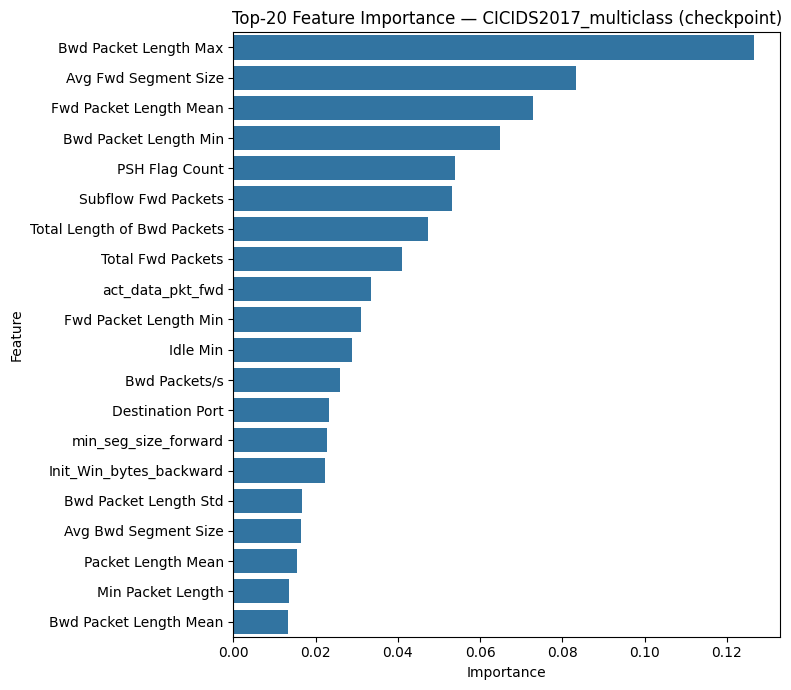

📊 Gráfico guardado en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/CICIDS2017_multiclass/figs/CICIDS2017_multiclass_feature_importance_top20.png
✅ Bloque 7 completado (modo LOAD).
⏱ Fin bloque 7 - XGBoost Feature Importance + selección Top-N (duración: 5.35 s)


In [23]:
## ============================================================
## 7) XGBoost Feature Importance + Selección de Top-N Features — v6.1
## ============================================================

from xgboost import XGBClassifier
import os, json

# 1) Elegir la fuente correcta (salida del Bloque 6)
if 'X_for_fs' in locals() and 'y_for_fs' in locals():
    X_fs = X_for_fs
    y_fs = y_for_fs
    _append_log("📌 FS: usando X_for_fs / y_for_fs (Bloque 6, respeta SMOTE_MODE).")
else:
    X_fs = X_train
    y_fs = y_train
    _append_log("📌 FS: usando X_train / y_train (fallback).")

TOP_N_FEATURES = 20  # Ajustable

with timed_block("7 - XGBoost Feature Importance + selección Top-N"):

    # ----------------------------
    # Validaciones
    # ----------------------------
    if 'X_train' not in locals() or 'y_train' not in locals():
        raise ValueError("❌ Ejecuta Bloques 5 y 6 antes del Bloque 7.")

    # ----------------------------
    # Obtener nombres de features
    # ----------------------------
    if hasattr(X, "columns"):
        feature_names = list(X.columns)
    else:
        feature_names = [f"f{i}" for i in range(X.shape[1])]

    n_features = len(feature_names)
    _append_log(f"🔍 Total de features numéricas: {n_features}")

    # ----------------------------
    # Rutas
    # ----------------------------
    xgb_model_path = os.path.join(CKPT_DIR, f"{RUN_TAG}_xgb_base.json")
    feat_meta_path = os.path.join(REP_DIR, f"{RUN_TAG}_selected_features.json")

    did_load = False

    # ============================================================
    # 1) LOAD MODE — si existe checkpoint
    # ============================================================
    if os.path.exists(xgb_model_path) and os.path.exists(feat_meta_path):
        did_load = True
        _append_log("♻️ Cargando checkpoint previo de XGBoost + lista de features…")

        xgb_clf = XGBClassifier()
        xgb_clf.load_model(xgb_model_path)

        # cargar metadata
        with open(feat_meta_path, "r") as f:
            meta = json.load(f)

        selected_features = meta["selected_features"]
        top_n = meta["top_n"]

        # mapa para índices
        feature_to_idx = {name: i for i, name in enumerate(feature_names)}
        selected_idx = [feature_to_idx[f] for f in selected_features]

        # reconstruir matrices seleccionadas
        X_train_sel = X_train[:, selected_idx]
        X_test_sel  = X_test[:, selected_idx]

        _append_log(f"👉 Top-{top_n} features restauradas: {selected_features}")

        # Importancias completas desde el modelo cargado
        importances = xgb_clf.feature_importances_

        imp_df = (
            pd.DataFrame({
                "feature": feature_names,
                "importance": importances
            })
            .sort_values("importance", ascending=False)
            .reset_index(drop=True)
        )
        imp_df["rank"] = imp_df.index + 1

        # Guardar tabla full
        full_csv = os.path.join(REP_DIR, f"{RUN_TAG}_feature_importance_full.csv")
        save_and_display_table(imp_df, full_csv, note="Full ranking (checkpoint)")

        # Top-N
        imp_top = imp_df[imp_df["feature"].isin(selected_features)]
        top_csv = os.path.join(REP_DIR, f"{RUN_TAG}_feature_importance_top{top_n}.csv")
        save_and_display_table(imp_top, top_csv, note="Top-N (checkpoint)")

        # gráfico
        plt.figure(figsize=(8, max(4, top_n * 0.35)))
        sns.barplot(
            x="importance", y="feature",
            data=imp_top.sort_values("importance", ascending=False),
            orient="h"
        )
        plt.title(f"Top-{top_n} Feature Importance — {RUN_TAG} (checkpoint)")
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        fig_path_imp = os.path.join(FIG_DIR, f"{RUN_TAG}_feature_importance_top{top_n}.png")
        show_and_save_current_fig(fig_path_imp)

        _append_log("✅ Bloque 7 completado (modo LOAD).")

    # ============================================================
    # 2) TRAIN MODE — si no existe checkpoint previo
    # ============================================================
    if not did_load:
        _append_log("🚀 No hay checkpoint. Entrenando XGBoost para selección de features…")

        # parámetros
        xgb_params = {
            "n_estimators": 200,
            "max_depth": 6,
            "learning_rate": 0.1,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "objective": "multi:softprob" if len(np.unique(y_fs)) > 2 else "binary:logistic",
            "tree_method": "hist",
            "n_jobs": -1,
            "eval_metric": "mlogloss" if len(np.unique(y_fs)) > 2 else "logloss",
            "random_state": 42,
        }

        t0 = time.time()
        xgb_clf = XGBClassifier(**xgb_params)
        xgb_clf.fit(X_fs, y_fs)
        t_train_xgb = time.time() - t0
        _append_log(f"⏱ XGBoost entrenado en {t_train_xgb:.2f} s.")

        # Importancias
        importances = xgb_clf.feature_importances_

        imp_df = (
            pd.DataFrame({
                "feature": feature_names,
                "importance": importances
            })
            .sort_values(by="importance", ascending=False)
            .reset_index(drop=True)
        )
        imp_df["rank"] = imp_df.index + 1

        # Tabla full
        full_csv = os.path.join(REP_DIR, f"{RUN_TAG}_feature_importance_full.csv")
        save_and_display_table(imp_df, full_csv, note="Full ranking (trained)")

        # top-n
        top_n = min(TOP_N_FEATURES, n_features)
        imp_top = imp_df.head(top_n).copy()

        top_csv = os.path.join(REP_DIR, f"{RUN_TAG}_feature_importance_top{top_n}.csv")
        save_and_display_table(imp_top, top_csv, note=f"Top-{top_n} features (trained)")

        # gráfico
        plt.figure(figsize=(8, max(4, top_n * 0.35)))
        sns.barplot(
            x="importance",
            y="feature",
            data=imp_top,
            orient="h"
        )
        plt.title(f"Top-{top_n} Feature Importance — {RUN_TAG}")
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        fig_path_imp = os.path.join(FIG_DIR, f"{RUN_TAG}_feature_importance_top{top_n}.png")
        show_and_save_current_fig(fig_path_imp)

        # Seleccionar features
        selected_features = imp_top["feature"].tolist()
        feature_to_idx = {name: i for i, name in enumerate(feature_names)}
        selected_idx = [feature_to_idx[f] for f in selected_features]

        X_train_sel = X_train[:, selected_idx]
        X_test_sel  = X_test[:, selected_idx]

        _append_log(
            f"✨ Top-{top_n} features seleccionadas. "
            f"X_train_sel={X_train_sel.shape}, X_test_sel={X_test_sel.shape}"
        )

        # Guardar metadata
        meta = {
            "run_tag": RUN_TAG,
            "top_n": top_n,
            "selected_features": selected_features,
            "train_time_xgb_s": t_train_xgb
        }
        save_json(meta, feat_meta_path)

        # Guardar modelo
        xgb_clf.save_model(xgb_model_path)
        record_model(f"{RUN_TAG}_xgb_base", xgb_model_path)
        _append_log(f"💾 Modelo XGBoost almacenado en: {xgb_model_path}")

        log_result({
            "block": "7_feature_importance",
            "dataset": DATASET,
            "task_mode": TASK_MODE,
            "top_n": top_n,
            "selected_features": selected_features,
            "train_time_xgb_s": t_train_xgb,
        })

        _append_log("✅ Bloque 7 completado (ENTRENAMIENTO).")


## 8) ML: entrenamiento con **checkpoints**, CMs y ROC

▶️ Inicio bloque 8 - Entrenamiento y evaluación de modelos ML (con checkpoint)
📌 ML: usando X_train_sel / X_test_sel (Top-N features de Bloque 7).
🔢 ML: n_classes=9 (is_binary=False), SMOTE_MODE=full.
🔹 ML: iniciando modelo RF…
♻️ RF: checkpoint cargado desde /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/CICIDS2017_multiclass/checkpoints/CICIDS2017_multiclass_RF_ML.pkl (no se reentrena).
⏱ RF: train_time_s original=2333.88s, smote_mode_guardado=full.
⏩ RF: usando modelo ya entrenado (train_time_s=2333.88s).
✅ RF: Acc=99.80%, Prec=99.80%, Rec=99.80%, F1=99.80%, MAE=0.008625, MSE=0.043327, RMSE=0.208152, AUC=99.99%, Train=2333.88s, Pred=26.22s, SMOTE_MODE=full.


,True\Pred,BENIGN,Bot,Brute Force,DDoS,DoS,Heartbleed,Infiltration,Port Scan,Web Attack
0,BENIGN,450589,519,64,9,2206,0,0,191,1041
1,Bot,73,454546,0,0,0,0,0,0,0
2,Brute Force,2,0,454618,0,0,0,0,0,0
3,DDoS,106,0,0,454425,89,0,0,0,0
4,DoS,113,0,0,23,454464,0,0,8,12
5,Heartbleed,0,0,0,0,0,454619,0,0,0
6,Infiltration,0,0,0,0,0,0,454620,0,0
7,Port Scan,96,0,0,0,153,0,0,454352,18
8,Web Attack,1,0,0,0,3485,0,0,0,451133


📄 Tabla guardada en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/CICIDS2017_multiclass/reports/CICIDS2017_multiclass_cm_RF.csv — Confusion matrix for RF


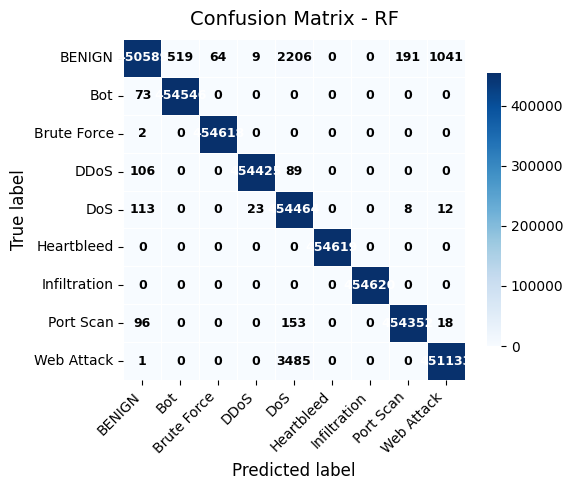

📊 Gráfico guardado en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/CICIDS2017_multiclass/figs/CICIDS2017_multiclass_cm_RF.png
🖼 Matriz de confusión de RF guardada en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/CICIDS2017_multiclass/figs/CICIDS2017_multiclass_cm_RF.png
✅ Bloque 8 completado (ML: entrenamiento/carga, métricas y matrices de confusión).
⏱ Fin bloque 8 - Entrenamiento y evaluación de modelos ML (con checkpoint) (duración: 65.08 s)


In [24]:
## ============================================================
## 8) Modelos ML (RF, DT, KNN, MLP, LightGBM, CatBoost) + checkpoint — v6.1
##     - Usa X_train_sel / X_test_sel si existen (Top-N por XGBoost)
##     - Métricas en porcentaje (Acc, Prec, Rec, F1, AUC)
##     - MAE/MSE/RMSE en escala normal
##     - Compatible con SMOTE_MODE (full / dynamic / none)
## ============================================================

import os, time, json, joblib
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    roc_auc_score,
    mean_absolute_error,
    mean_squared_error
)

with timed_block("8 - Entrenamiento y evaluación de modelos ML (con checkpoint)"):

    # ------------------------------------------------------
    # 0) Selección de X_train / X_test (Top-N o todas)
    # ------------------------------------------------------
    if 'X_train_sel' in locals() and 'X_test_sel' in locals():
        Xtr, Xte = X_train_sel, X_test_sel
        _append_log("📌 ML: usando X_train_sel / X_test_sel (Top-N features de Bloque 7).")
    else:
        Xtr, Xte = X_train, X_test
        _append_log("📌 ML: usando X_train / X_test (todas las features).")

    # Chequeos básicos
    if 'y_train' not in locals() or 'y_test' not in locals():
        raise ValueError("❌ y_train / y_test no definidos. Ejecuta primero los bloques 5 y 6.")

    if len(y_train) == 0 or len(y_test) == 0:
        raise ValueError("❌ y_train / y_test están vacíos. Revisa los bloques anteriores.")

    n_classes = len(np.unique(y_train))
    is_binary = (n_classes == 2)

    smote_mode_for_log = globals().get("SMOTE_MODE", "unknown")
    _append_log(
        f"🔢 ML: n_classes={n_classes} (is_binary={is_binary}), "
        f"SMOTE_MODE={smote_mode_for_log}."
    )

    results_ml = []
    probas_ml = {}

    # ------------------------------------------------------
    # 1) Fábrica de modelos por clave
    # ------------------------------------------------------
    def build_model(key: str):
        key = key.upper()
        if key == "RF":
            return RandomForestClassifier(
                n_estimators=200,
                max_depth=None,
                n_jobs=-1,
                random_state=42
            )
        elif key == "DT":
            return DecisionTreeClassifier(
                max_depth=None,
                random_state=42
            )
        elif key == "KNN":
            return KNeighborsClassifier(
                n_neighbors=5,
                n_jobs=-1
            )
        elif key == "MLP":
            return MLPClassifier(
                hidden_layer_sizes=(128, 64),
                activation='relu',
                batch_size=256,
                max_iter=30,
                random_state=42
            )
        elif key == "LIGHTGBM":
            return LGBMClassifier(
                n_estimators=200,
                learning_rate=0.1,
                max_depth=-1,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
                n_jobs=-1
            )
        elif key == "CATBOOST":
            return CatBoostClassifier(
                iterations=300,
                depth=6,
                learning_rate=0.1,
                loss_function='MultiClass' if not is_binary else 'Logloss',
                verbose=False,
                random_state=42
            )
        else:
            raise ValueError(f"Modelo ML desconocido: {key}")

    # ------------------------------------------------------
    # 2) Loop principal por modelo en ML_TO_RUN
    # ------------------------------------------------------
    for key in ML_TO_RUN:
        model_name = key.upper()
        _append_log(f"🔹 ML: iniciando modelo {model_name}…")

        model_ckpt_path = os.path.join(CKPT_DIR, f"{RUN_TAG}_{model_name}_ML.pkl")
        meta_ckpt_path  = os.path.join(REP_DIR,  f"{RUN_TAG}_{model_name}_ML_meta.json")

        model = None
        t_train = np.nan
        loaded_from_ckpt = False

        # -------------------------------
        # 2.1 Intentar cargar checkpoint
        # -------------------------------
        if os.path.exists(model_ckpt_path):
            try:
                model = joblib.load(model_ckpt_path)
                loaded_from_ckpt = True
                _append_log(
                    f"♻️ {model_name}: checkpoint cargado desde {model_ckpt_path} "
                    "(no se reentrena)."
                )

                if os.path.exists(meta_ckpt_path):
                    try:
                        with open(meta_ckpt_path, "r") as f:
                            meta = json.load(f)
                        t_train = meta.get("train_time_s", np.nan)
                        meta_smote = meta.get("smote_mode", "N/A")
                        _append_log(
                            f"⏱ {model_name}: train_time_s original={ 'NaN' if np.isnan(t_train) else f'{t_train:.2f}s' }, "
                            f"smote_mode_guardado={meta_smote}."
                        )
                    except Exception as e:
                        _append_log(
                            f"⚠️ {model_name}: no se pudo leer meta JSON ({e}); "
                            "train_time_s quedará como NaN."
                        )
            except Exception as e:
                _append_log(
                    f"⚠️ {model_name}: error al cargar checkpoint ({e}). "
                    "Se procederá a reentrenar el modelo."
                )
                model = None
                loaded_from_ckpt = False
                t_train = np.nan

        # -------------------------------
        # 2.2 Si no hay checkpoint → entrenar
        # -------------------------------
        if model is None:
            model = build_model(model_name)
            t0 = time.time()
            model.fit(Xtr, y_train)
            t_train = time.time() - t0
            _append_log(f"✅ {model_name}: entrenado desde cero en {t_train:.2f} s.")

            # Guardar checkpoint del modelo
            try:
                joblib.dump(model, model_ckpt_path)
                record_model(f"{RUN_TAG}_{model_name}_ML", model_ckpt_path)
                _append_log(f"💾 {model_name}: modelo guardado en {model_ckpt_path}.")
            except Exception as e:
                _append_log(f"⚠️ {model_name}: no se pudo guardar el checkpoint ({e}).")

            # Guardar meta con train_time_s + SMOTE_MODE
            try:
                meta = {
                    "run_tag": RUN_TAG,
                    "model": model_name,
                    "dataset": DATASET,
                    "task_mode": TASK_MODE,
                    "train_time_s": t_train,
                    "smote_mode": smote_mode_for_log
                }
                save_json(meta, meta_ckpt_path)
                _append_log(
                    f"📝 {model_name}: meta (incluye train_time_s y smote_mode={smote_mode_for_log}) "
                    f"guardada en {meta_ckpt_path}."
                )
            except Exception as e:
                _append_log(f"⚠️ {model_name}: no se pudo guardar meta JSON ({e}).")
        else:
            _append_log(
                f"⏩ {model_name}: usando modelo ya entrenado "
                f"(train_time_s={ 'NaN' if np.isnan(t_train) else f'{t_train:.2f}s' })."
            )

        # ------------------------------------------------------
        # 3) Predicción y probabilidades
        # ------------------------------------------------------
        t1 = time.time()
        y_pred = model.predict(Xte)
        t_pred = time.time() - t1

        y_proba = None
        if hasattr(model, "predict_proba"):
            try:
                y_proba = model.predict_proba(Xte)
            except Exception as e:
                _append_log(f"⚠️ {model_name}: error en predict_proba: {e}")
                y_proba = None

        # ------------------------------------------------------
        # 4) Métricas crudas (0–1) y erroes
        # ------------------------------------------------------
        acc = accuracy_score(y_test, y_pred)
        prec, rec, f1, _ = precision_recall_fscore_support(
            y_test, y_pred,
            average='macro',
            zero_division=0
        )

        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)

        # AUC
        auc_val = None
        try:
            if is_binary and (y_proba is not None) and (y_proba.shape[1] >= 2):
                auc_val = roc_auc_score(y_test, y_proba[:, 1])
            elif (not is_binary) and (y_proba is not None):
                auc_val = roc_auc_score(
                    y_test,
                    y_proba,
                    multi_class='ovr',
                    average='macro'
                )
        except Exception as e:
            _append_log(f"⚠️ {model_name}: error al calcular AUC: {e}")
            auc_val = None

        # ------------------------------------------------------
        # 5) Pasar a porcentaje (estilo paper)
        # ------------------------------------------------------
        acc_pct = acc * 100
        prec_pct = prec * 100
        rec_pct  = rec * 100
        f1_pct   = f1 * 100
        auc_pct  = auc_val * 100 if auc_val is not None else None

        results_ml.append({
            "Model": model_name,
            "Accuracy (%)": acc_pct,
            "Precision (%)": prec_pct,
            "Recall (%)": rec_pct,
            "F1-score (%)": f1_pct,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "AUC (%)": auc_pct,
            "Train_time_s": t_train,
            "Predict_time_s": t_pred,
            "Loaded_from_ckpt": loaded_from_ckpt,
            "SMOTE_MODE": smote_mode_for_log
        })
        probas_ml[model_name] = y_proba

        _append_log(
            f"✅ {model_name}: "
            f"Acc={acc_pct:.2f}%, Prec={prec_pct:.2f}%, Rec={rec_pct:.2f}%, F1={f1_pct:.2f}%, "
            f"MAE={mae:.6f}, MSE={mse:.6f}, RMSE={rmse:.6f}, "
            f"AUC={'{:.2f}%'.format(auc_pct) if auc_pct is not None else 'N/A'}, "
            f"Train={'NaN (ckpt)' if np.isnan(t_train) else f'{t_train:.2f}s'}, "
            f"Pred={t_pred:.2f}s, SMOTE_MODE={smote_mode_for_log}."
        )

        # ------------------------------------------------------
        # 6) Matriz de confusión + gráfico tipo paper
        # ------------------------------------------------------
        cm = confusion_matrix(y_test, y_pred)
        cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

        cm_csv = os.path.join(REP_DIR, f"{RUN_TAG}_cm_{model_name}.csv")
        save_and_display_table(
            cm_df.reset_index().rename(columns={'index': 'True\\Pred'}),
            cm_csv,
            note=f"Confusion matrix for {model_name}"
        )

        fig, ax = plt.subplots(figsize=(6, 5))
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            square=True,
            linewidths=0.5,
            linecolor='white',
            cbar_kws={"shrink": 0.8},
            ax=ax,
            annot_kws={"fontsize": 9, "fontweight": "bold"}
        )

        ax.set_title(f"Confusion Matrix - {model_name}", fontsize=14, pad=10)
        ax.set_xlabel("Predicted label", fontsize=12)
        ax.set_ylabel("True label", fontsize=12)

        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

        # --- Color dinámico del texto: negro en celdas claras, blanco en celdas oscuras ---
        # Umbral basado en la mitad del valor máximo de la matriz
        threshold = cm.max() / 2.0 if cm.max() > 0 else 0

        for text in ax.texts:
            # posición del texto → índice (fila, col)
            x, y = text.get_position()  # (col+0.5, fila+0.5)
            j = int(round(x - 0.5))
            i = int(round(y - 0.5))

            value = cm[i, j]
            if value > threshold:
                text.set_color("white")
            else:
                text.set_color("black")
            text.set_fontweight('bold')

        fig.tight_layout()
        cm_fig_path = os.path.join(FIG_DIR, f"{RUN_TAG}_cm_{model_name}.png")
        show_and_save_current_fig(cm_fig_path)
        _append_log(f"🖼 Matriz de confusión de {model_name} guardada en: {cm_fig_path}")

        # ------------------------------------------------------
        # 7) Registrar en resumen global
        # ------------------------------------------------------
        log_result({
            "block": "8_ml",
            "dataset": DATASET,
            "task_mode": TASK_MODE,
            "model": model_name,
            "accuracy_pct": acc_pct,
            "precision_pct": prec_pct,
            "recall_pct": rec_pct,
            "f1_pct": f1_pct,
            "mae": mae,
            "mse": mse,
            "rmse": rmse,
            "auc_pct": auc_pct,
            "train_time_s": t_train,
            "predict_time_s": t_pred,
            "loaded_from_ckpt": loaded_from_ckpt,
            "smote_mode": smote_mode_for_log
        })

    _append_log("✅ Bloque 8 completado (ML: entrenamiento/carga, métricas y matrices de confusión).")


## BLOQUE 8b — Tabla comparativa ML + ROC comparativa

▶️ Inicio bloque 8b - Comparativo ML y ROC
📊 Iniciando comparativo de modelos ML (Bloque 8b)…
  Model  Accuracy (%)  Precision (%)  Recall (%)  F1-score (%)       MAE  \
0    RF     99.799368      99.800983   99.799368     99.799475  0.008625   

        MSE      RMSE    AUC (%)  Train_time_s  Predict_time_s  \
0  0.043327  0.208152  99.986999   2333.882665       26.218247   

   Loaded_from_ckpt SMOTE_MODE  
0              True       full  


,Model,Accuracy (%),Precision (%),Recall (%),F1-score (%),MAE,MSE,RMSE,AUC (%),Train_time_s,Predict_time_s,Loaded_from_ckpt,SMOTE_MODE
0,RF,99.799368,99.800983,99.799368,99.799475,0.008625,0.043327,0.208152,99.986999,2333.882665,26.218247,True,full


📄 Tabla guardada en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/CICIDS2017_multiclass/reports/CICIDS2017_multiclass_ml_results_comparative.csv — Comparative metrics of all ML models (sorted by F1-score (%))


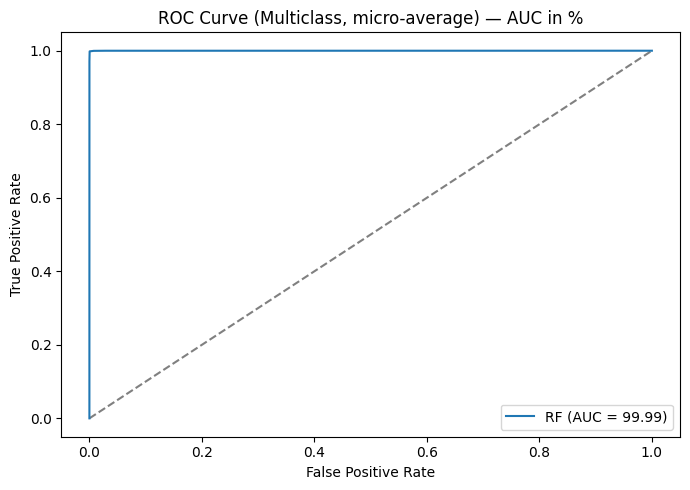

📊 Gráfico guardado en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/CICIDS2017_multiclass/figs/CICIDS2017_multiclass_ml_roc_models_multiclass.png
🖼 Curva ROC comparativa guardada en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/CICIDS2017_multiclass/figs/CICIDS2017_multiclass_ml_roc_models_multiclass.png
✅ Bloque 8b completado (tabla comparativa + ROC ML binaria/multiclase en %).
⏱ Fin bloque 8b - Comparativo ML y ROC (duración: 13.26 s)


In [25]:
## 8b) Comparativo final de modelos ML + ROC (binaria y multiclase) — v4.4.0
##     Accuracy / Precision / Recall / F1 / AUC en porcentaje en la tabla y en el gráfico (AUC).

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

pd.set_option("display.max_columns", None)

with timed_block("8b - Comparativo ML y ROC"):
    if 'results_ml' not in locals() or not isinstance(results_ml, list) or len(results_ml) == 0:
        msg = ("ℹ️ Bloque 8b omitido: no hay resultados en `results_ml`. "
               "Ejecuta el Bloque 8 antes de este.")
        _append_log(msg)
        print(msg)
    else:
        _append_log("📊 Iniciando comparativo de modelos ML (Bloque 8b)…")

        # 1) Tabla comparativa completa (estilo paper)
        results_df = (
            pd.DataFrame(results_ml)
            .sort_values(by="F1-score (%)", ascending=False)
            .reset_index(drop=True)
        )

        print(results_df)

        comp_csv = os.path.join(REP_DIR, f"{RUN_TAG}_ml_results_comparative.csv")
        save_and_display_table(
            results_df,
            comp_csv,
            note="Comparative metrics of all ML models (sorted by F1-score (%))"
        )

        # 2) Preparar información de clases
        y_true = np.asarray(y_test)
        classes_sorted = np.unique(y_true)
        n_classes = len(classes_sorted)
        is_binary = (n_classes == 2)

        # 3) Construir curvas ROC por modelo (AUC crudo → label en %)
        roc_models = []  # (name, fpr, tpr, auc_val_decimal)
        for row in results_ml:
            name = row.get("Model", "ML")
            y_proba = probas_ml.get(name)

            if y_proba is None:
                _append_log(f"⚠️ ROC: modelo {name} no tiene probabilidades, se omite.")
                continue

            try:
                if is_binary:
                    # ROC binaria clásica
                    if y_proba.ndim != 2 or y_proba.shape[1] < 2:
                        _append_log(f"⚠️ ROC: salida de predict_proba de {name} no es binaria válida.")
                        continue

                    fpr, tpr, _ = roc_curve(y_true, y_proba[:, 1])
                    auc_val = roc_auc_score(y_true, y_proba[:, 1])

                else:
                    # ROC multiclase (micro-average)
                    y_true_bin = label_binarize(y_true, classes=classes_sorted)
                    if y_proba.shape[1] != y_true_bin.shape[1]:
                        _append_log(
                            f"⚠️ ROC: dimensiones proba vs clases no coinciden para {name}. "
                            f"y_proba.shape={y_proba.shape}, y_true_bin.shape={y_true_bin.shape}"
                        )
                        continue

                    fpr, tpr, _ = roc_curve(
                        y_true_bin.ravel(),
                        y_proba.ravel()
                    )
                    auc_val = roc_auc_score(
                        y_true_bin,
                        y_proba,
                        average="micro",
                        multi_class="ovr"
                    )

                roc_models.append((name, fpr, tpr, auc_val))

            except Exception as e:
                _append_log(f"⚠️ ROC: error calculando curva para {name}: {e}")

        # 4) Dibujar gráfico ROC si hay modelos válidos
        if len(roc_models) == 0:
            msg = "ℹ️ No se encontraron modelos con probabilidades válidas para dibujar la ROC."
            _append_log(msg)
            print(msg)
        else:
            plt.figure(figsize=(7, 5))
            plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

            for name, fpr, tpr, auc_val in roc_models:
                label = f"{name} (AUC = {auc_val*100:.2f})"  # AUC en porcentaje
                plt.plot(fpr, tpr, label=label)

            if is_binary:
                title = "ROC Curve (Binary) — AUC in %"
                filename = f"{RUN_TAG}_ml_roc_models_binary.png"
            else:
                title = "ROC Curve (Multiclass, micro-average) — AUC in %"
                filename = f"{RUN_TAG}_ml_roc_models_multiclass.png"

            plt.title(title)
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.legend(loc="lower right")

            roc_path = os.path.join(FIG_DIR, filename)
            show_and_save_current_fig(roc_path)
            _append_log(f"🖼 Curva ROC comparativa guardada en: {roc_path}")

        _append_log("✅ Bloque 8b completado (tabla comparativa + ROC ML binaria/multiclase en %).")

## 9) DL: GPU, **mixed precision**, lotes dinámicos + ANN/CNN1D/LSTM/AE+LR

In [26]:
## ============================================================
## 9) Modelos Deep Learning (ANN, CNN1D, LSTM, AE_LR) con checkpoint — v6.1
##    - Usa X_train_sel/X_test_sel si existen (Top-N por XGBoost)
##    - Compatible con SMOTE_MODE (full / dynamic / none)
##    - Métricas en porcentaje, errores en escala normal
##    - Matriz de confusión con texto negro/blanco según intensidad
## ============================================================

import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    roc_auc_score,
    mean_absolute_error,
    mean_squared_error
)

with timed_block("9 - Entrenamiento y evaluación de modelos DL (con checkpoint)"):

    # ------------------------------------------------------
    # 0) Selección de features (Top-N o todas)
    # ------------------------------------------------------
    if 'X_train_sel' in locals() and 'X_test_sel' in locals():
        Xtr = np.asarray(X_train_sel)
        Xte = np.asarray(X_test_sel)
        _append_log("📌 DL: usando X_train_sel / X_test_sel (Top-N features de Bloque 7).")
    else:
        Xtr = np.asarray(X_train)
        Xte = np.asarray(X_test)
        _append_log("📌 DL: usando X_train / X_test (todas las features).")

    if 'y_train' not in locals() or 'y_test' not in locals():
        raise ValueError("❌ y_train / y_test no definidos. Ejecuta bloques 5 y 6 antes del 9.")

    ytr = np.asarray(y_train, dtype=int)
    yte = np.asarray(y_test, dtype=int)

    n_classes = len(np.unique(ytr))
    is_binary = (n_classes == 2)
    n_features = Xtr.shape[1]

    smote_mode_for_log = globals().get("SMOTE_MODE", "unknown")
    _append_log(
        f"🔢 DL: n_samples_train={Xtr.shape[0]}, n_features={n_features}, "
        f"n_classes={n_classes}, SMOTE_MODE={smote_mode_for_log}."
    )

    # ------------------------------------------------------
    # 1) Etiquetas para Keras
    # ------------------------------------------------------
    if is_binary:
        # Forma (N,1) para evitar problemas con binary_crossentropy
        ytr_keras = ytr.astype("float32").reshape(-1, 1)
        yte_keras = yte.astype("float32").reshape(-1, 1)
        output_units = 1
        output_activation = "sigmoid"
        loss_fn = "binary_crossentropy"
    else:
        ytr_keras = keras.utils.to_categorical(ytr, num_classes=n_classes)
        yte_keras = keras.utils.to_categorical(yte, num_classes=n_classes)
        output_units = n_classes
        output_activation = "softmax"
        loss_fn = "categorical_crossentropy"

    # ------------------------------------------------------
    # 2) Builders de modelos DL clásicos (ANN, CNN1D, LSTM)
    # ------------------------------------------------------
    def build_dl_model(key: str, input_dim: int):
        key = key.upper()
        if key == "ANN":
            inputs = keras.Input(shape=(input_dim,))
            x = keras.layers.Dense(128, activation="relu")(inputs)
            x = keras.layers.Dropout(0.3)(x)
            x = keras.layers.Dense(64, activation="relu")(x)
            outputs = keras.layers.Dense(output_units, activation=output_activation)(x)
            model = keras.Model(inputs, outputs, name="ANN")

        elif key == "CNN1D":
            inputs = keras.Input(shape=(input_dim, 1))
            x = keras.layers.Conv1D(64, 3, activation="relu", padding="same")(inputs)
            x = keras.layers.MaxPooling1D(2)(x)
            x = keras.layers.Conv1D(64, 3, activation="relu", padding="same")(x)
            x = keras.layers.GlobalMaxPooling1D()(x)
            x = keras.layers.Dense(64, activation="relu")(x)
            outputs = keras.layers.Dense(output_units, activation=output_activation)(x)
            model = keras.Model(inputs, outputs, name="CNN1D")

        elif key == "LSTM":
            inputs = keras.Input(shape=(input_dim, 1))
            x = keras.layers.LSTM(64, return_sequences=False)(inputs)
            x = keras.layers.Dense(64, activation="relu")(x)
            outputs = keras.layers.Dense(output_units, activation=output_activation)(x)
            model = keras.Model(inputs, outputs, name="LSTM")

        else:
            raise ValueError(f"Modelo DL desconocido (builder clásico): {key}")

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=1e-3),
            loss=loss_fn,
            metrics=["accuracy"]
        )
        return model

    # ------------------------------------------------------
    # 3) Builder específico AE_LR (Autoencoder + cabeza clasificador)
    # ------------------------------------------------------
    def build_ae_lr(input_dim: int):
        """
        Autoencoder + cabeza lineal:
        - 'reconstruction': reconstruye X (MSE)
        - 'classifier': clasifica (binaria o multiclase)
        """
        latent_dim = min(32, max(4, input_dim // 2))

        inp = keras.Input(shape=(input_dim,), name="input")
        # Encoder
        x = keras.layers.Dense(64, activation="relu")(inp)
        bottleneck = keras.layers.Dense(latent_dim, activation="relu", name="bottleneck")(x)

        # Reconstrucción
        dec = keras.layers.Dense(64, activation="relu")(bottleneck)
        recon = keras.layers.Dense(input_dim, activation="linear", name="reconstruction")(dec)

        # Clasificador
        cls = keras.layers.Dense(32, activation="relu")(bottleneck)
        clf_out = keras.layers.Dense(output_units, activation=output_activation, name="classifier")(cls)

        model = keras.Model(
            inputs=inp,
            outputs={"reconstruction": recon, "classifier": clf_out},
            name="AE_LR"
        )

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=1e-3),
            loss={
                "reconstruction": "mse",
                "classifier": loss_fn
            },
            loss_weights={"reconstruction": 0.5, "classifier": 1.0},
            metrics={"classifier": ["accuracy"]}
        )
        return model

    # ------------------------------------------------------
    # 4) Datos 3D para CNN/LSTM
    # ------------------------------------------------------
    Xtr_seq = Xtr.reshape((Xtr.shape[0], n_features, 1))
    Xte_seq = Xte.reshape((Xte.shape[0], n_features, 1))

    # ------------------------------------------------------
    # 5) Callbacks (EarlyStopping + ModelCheckpoint)
    # ------------------------------------------------------
    def make_callbacks(model_name: str):
        best_ckpt_path = os.path.join(CKPT_DIR, f"{RUN_TAG}_{model_name}_DL_best.weights.h5")
        es = keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=3,
            restore_best_weights=True
        )
        mc = keras.callbacks.ModelCheckpoint(
            best_ckpt_path,
            monitor="val_loss",
            save_best_only=True,
            save_weights_only=True,
            verbose=0
        )
        return [es, mc], best_ckpt_path

    results_dl = []
    probas_dl = {}

    # ------------------------------------------------------
    # 6) Loop principal DL_TO_RUN
    # ------------------------------------------------------
    for key in DL_TO_RUN:
        dl_name = key.upper()
        _append_log(f"🔹 DL: iniciando modelo {dl_name}…")

        if dl_name in ("CNN1D", "LSTM"):
            Xtrain_used = Xtr_seq
            Xtest_used = Xte_seq
        else:
            Xtrain_used = Xtr
            Xtest_used = Xte

        final_model_path = os.path.join(CKPT_DIR, f"{RUN_TAG}_{dl_name}_DL_final.keras")

        model = None
        loaded_from_ckpt = False
        t_train = np.nan

        # 6.1 Intentar cargar modelo desde checkpoint
        if os.path.exists(final_model_path):
            try:
                model = keras.models.load_model(final_model_path)
                loaded_from_ckpt = True
                _append_log(
                    f"♻️ {dl_name}: modelo DL cargado desde checkpoint {final_model_path} "
                    "(no se reentrena)."
                )
            except Exception as e:
                _append_log(
                    f"⚠️ {dl_name}: error al cargar modelo desde {final_model_path} ({e}). "
                    "Se procederá a reentrenar."
                )
                model = None
                loaded_from_ckpt = False

        # 6.2 Si no hay modelo guardado → entrenar
        if model is None:
            if dl_name == "AE_LR":
                model = build_ae_lr(input_dim=n_features)
            else:
                model = build_dl_model(dl_name, input_dim=n_features)

            callbacks, best_ckpt_path = make_callbacks(dl_name)

            batch_size = 256
            epochs = 20

            t0 = time.time()
            if dl_name == "AE_LR":
                # Targets para la cabeza classifier del AE
                if is_binary:
                    ytr_cls = ytr.astype("float32").reshape(-1, 1)
                    yte_cls = yte.astype("float32").reshape(-1, 1)
                else:
                    ytr_cls = ytr_keras
                    yte_cls = yte_keras

                history = model.fit(
                    Xtrain_used,
                    {"reconstruction": Xtrain_used, "classifier": ytr_cls},
                    validation_data=(
                        Xtest_used,
                        {"reconstruction": Xtest_used, "classifier": yte_cls}
                    ),
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=callbacks,
                    verbose=0
                )
            else:
                history = model.fit(
                    Xtrain_used,
                    ytr_keras,
                    validation_split=0.2,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=callbacks,
                    verbose=0
                )
            t_train = time.time() - t0

            _append_log(
                f"✅ {dl_name}: entrenamiento finalizado en {t_train:.2f} s "
                f"({len(history.history['loss'])} épocas efectivas)."
            )

            # Restaurar mejores pesos
            try:
                model.load_weights(best_ckpt_path)
                _append_log(f"💾 {dl_name}: pesos restaurados desde {best_ckpt_path}.")
            except Exception as e:
                _append_log(f"⚠️ {dl_name}: no se pudieron cargar pesos desde {best_ckpt_path} ({e}).")

            # Guardar modelo final
            try:
                model.save(final_model_path)
                record_model(f"{RUN_TAG}_{dl_name}_DL", final_model_path)
                _append_log(f"💾 Modelo DL {dl_name} guardado en: {final_model_path}")
            except Exception as e:
                _append_log(f"⚠️ {dl_name}: no se pudo guardar el modelo DL completo ({e}).")
        else:
            _append_log(f"⏩ {dl_name}: usando modelo DL ya entrenado (t_train_s=NaN, ckpt).")

        # ------------------------------------------------------
        # 7) Predicción
        # ------------------------------------------------------
        batch_size = 256
        t1 = time.time()
        if dl_name == "AE_LR":
            preds = model.predict(Xtest_used, batch_size=batch_size, verbose=0)
            # Para modelos funcionales con dict de salidas
            y_proba_raw = preds["classifier"]
        else:
            y_proba_raw = model.predict(Xtest_used, batch_size=batch_size, verbose=0)
        t_pred = time.time() - t1

        # ------------------------------------------------------
        # 8) Probabilidades → etiquetas
        # ------------------------------------------------------
        if is_binary:
            y_scores = y_proba_raw.ravel()
            y_pred = (y_scores >= 0.5).astype(int)
            y_proba_for_auc = np.stack([1 - y_scores, y_scores], axis=1)
        else:
            y_pred = np.argmax(y_proba_raw, axis=1)
            y_proba_for_auc = y_proba_raw

        # ------------------------------------------------------
        # 9) Métricas
        # ------------------------------------------------------
        acc = accuracy_score(yte, y_pred)
        prec, rec, f1, _ = precision_recall_fscore_support(
            yte, y_pred,
            average='macro',
            zero_division=0
        )

        mae = mean_absolute_error(yte, y_pred)
        mse = mean_squared_error(yte, y_pred)
        rmse = np.sqrt(mse)

        auc_val = None
        try:
            if is_binary:
                auc_val = roc_auc_score(yte, y_proba_for_auc[:, 1])
            else:
                auc_val = roc_auc_score(
                    yte,
                    y_proba_for_auc,
                    multi_class='ovr',
                    average='macro'
                )
        except Exception as e:
            _append_log(f"⚠️ {dl_name}: error al calcular AUC ({e}).")
            auc_val = None

        # 10) Convertir a porcentaje
        acc_pct = acc * 100
        prec_pct = prec * 100
        rec_pct  = rec * 100
        f1_pct   = f1 * 100
        auc_pct  = auc_val * 100 if auc_val is not None else None

        results_dl.append({
            "Model": dl_name,
            "Accuracy (%)": acc_pct,
            "Precision (%)": prec_pct,
            "Recall (%)": rec_pct,
            "F1-score (%)": f1_pct,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "AUC (%)": auc_pct,
            "Train_time_s": t_train,
            "Predict_time_s": t_pred,
            "Loaded_from_ckpt": loaded_from_ckpt,
            "SMOTE_MODE": smote_mode_for_log
        })
        probas_dl[dl_name] = y_proba_for_auc

        _append_log(
            f"✅ {dl_name}: Acc={acc_pct:.2f}%, Prec={prec_pct:.2f}%, Rec={rec_pct:.2f}%, "
            f"F1={f1_pct:.2f}%, MAE={mae:.6f}, MSE={mse:.6f}, RMSE={rmse:.6f}, "
            f"AUC={'%.2f%%' % auc_pct if auc_pct is not None else 'N/A'}, "
            f"Train={'NaN (ckpt)' if np.isnan(t_train) else f'{t_train:.2f}s'}, "
            f"Pred={t_pred:.2f}s, SMOTE_MODE={smote_mode_for_log}."
        )

        # ------------------------------------------------------
        # 11) Matriz de confusión con texto adaptativo (negro/blanco)
        # ------------------------------------------------------
        cm = confusion_matrix(yte, y_pred)
        cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

        cm_csv = os.path.join(REP_DIR, f"{RUN_TAG}_cm_{dl_name}_DL.csv")
        save_and_display_table(
            cm_df.reset_index().rename(columns={'index': 'True\\Pred'}),
            cm_csv,
            note=f"Confusion matrix for DL model {dl_name}"
        )

        fig, ax = plt.subplots(figsize=(6, 5))
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            square=True,
            linewidths=0.5,
            linecolor='white',
            cbar_kws={"shrink": 0.8},
            ax=ax,
            annot_kws={"fontsize": 9, "fontweight": "bold"}
        )

        ax.set_title(f"Confusion Matrix - {dl_name} (DL)", fontsize=14, pad=10)
        ax.set_xlabel("Predicted label", fontsize=12)
        ax.set_ylabel("True label", fontsize=12)

        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

        # Umbral para cambiar color del texto
        threshold = cm.max() / 2.0 if cm.max() > 0 else 0

        for text in ax.texts:
            x, y_pos = text.get_position()  # (col+0.5, fila+0.5)
            j = int(round(x - 0.5))
            i = int(round(y_pos - 0.5))
            value = cm[i, j]
            if value > threshold:
                text.set_color("white")
            else:
                text.set_color("black")
            text.set_fontweight("bold")

        fig.tight_layout()
        cm_fig_path = os.path.join(FIG_DIR, f"{RUN_TAG}_cm_{dl_name}_DL.png")
        show_and_save_current_fig(cm_fig_path)
        _append_log(f"🖼 Matriz de confusión DL {dl_name} guardada en: {cm_fig_path}")

        # ------------------------------------------------------
        # 12) Registrar en resumen global
        # ------------------------------------------------------
        log_result({
            "block": "9_dl",
            "dataset": DATASET,
            "task_mode": TASK_MODE,
            "model": dl_name,
            "accuracy_pct": acc_pct,
            "precision_pct": prec_pct,
            "recall_pct": rec_pct,
            "f1_pct": f1_pct,
            "mae": mae,
            "mse": mse,
            "rmse": rmse,
            "auc_pct": auc_pct,
            "train_time_s": t_train,
            "predict_time_s": t_pred,
            "loaded_from_ckpt": loaded_from_ckpt,
            "smote_mode": smote_mode_for_log
        })

    _append_log("✅ Bloque 9 completado (DL: entrenamiento/carga, métricas y matrices de confusión).")


▶️ Inicio bloque 9 - Entrenamiento y evaluación de modelos DL (con checkpoint)
📌 DL: usando X_train_sel / X_test_sel (Top-N features de Bloque 7).
🔢 DL: n_samples_train=16366298, n_features=20, n_classes=9, SMOTE_MODE=full.
✅ Bloque 9 completado (DL: entrenamiento/carga, métricas y matrices de confusión).
⏱ Fin bloque 9 - Entrenamiento y evaluación de modelos DL (con checkpoint) (duración: 1.59 s)


## BLOQUE 9b — Comparativo DL + ROC comparativa (solo binario)

In [27]:
## 9b) Comparativo final de modelos DL + ROC — v4.4.0
##     Accuracy / Precision / Recall / F1 / AUC en porcentaje.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

pd.set_option("display.max_columns", None)

with timed_block("9b - Comparativo DL y ROC"):
    if 'results_dl' not in locals() or not isinstance(results_dl, list) or len(results_dl) == 0:
        msg = ("ℹ️ Bloque 9b omitido: no hay resultados en `results_dl`. "
               "Ejecuta el Bloque 9 antes de este.")
        _append_log(msg)
        print(msg)
    else:
        _append_log("📊 Iniciando comparativo de modelos DL (Bloque 9b)…")

        results_df = (
            pd.DataFrame(results_dl)
            .sort_values(by="F1-score (%)", ascending=False)
            .reset_index(drop=True)
        )

        print(results_df)

        comp_csv = os.path.join(REP_DIR, f"{RUN_TAG}_dl_results_comparative.csv")
        save_and_display_table(
            results_df,
            comp_csv,
            note="Comparative metrics of all DL models (sorted by F1-score (%))"
        )

        # ROC solo si tarea binaria
        n_classes = len(np.unique(y_test))
        is_binary = (n_classes == 2)

        if not is_binary:
            msg = (f"ℹ️ Tarea multiclase (n_clases={n_classes}): "
                   "este bloque solo dibuja ROC comparativa para tareas binarias. "
                   "Se omite el gráfico ROC DL.")
            _append_log(msg)
            print(msg)
        else:
            roc_models = []
            for row in results_dl:
                name = row.get("Model", "DL")
                y_proba = probas_dl.get(name)
                if y_proba is None:
                    _append_log(f"⚠️ ROC DL: modelo {name} no tiene probabilidades; se omite.")
                    continue
                if y_proba.ndim != 2 or y_proba.shape[1] < 2:
                    _append_log(f"⚠️ ROC DL: salida de predict_proba de {name} no es binaria; se omite.")
                    continue

                try:
                    fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
                    auc_val = roc_auc_score(y_test, y_proba[:, 1])
                    roc_models.append((name, fpr, tpr, auc_val))
                except Exception as e:
                    _append_log(f"⚠️ ROC DL: error calculando curva para {name}: {e}")

            if len(roc_models) == 0:
                msg = "ℹ️ No se encontraron modelos DL con probabilidades válidas para ROC."
                _append_log(msg)
                print(msg)
            else:
                plt.figure(figsize=(7, 5))
                plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

                for name, fpr, tpr, auc_val in roc_models:
                    label = f"{name} (AUC = {auc_val*100:.2f})"
                    plt.plot(fpr, tpr, label=label)

                plt.title("ROC Curve — Deep Learning (AUC in %)")
                plt.xlabel("False Positive Rate")
                plt.ylabel("True Positive Rate")
                plt.legend(loc="lower right")

                roc_path = os.path.join(FIG_DIR, f"{RUN_TAG}_dl_roc_models.png")
                show_and_save_current_fig(roc_path)
                _append_log(f"🖼 Curva ROC DL comparativa guardada en: {roc_path}")

        _append_log("✅ Bloque 9b completado (tabla comparativa + ROC DL si aplica, AUC en %).")

▶️ Inicio bloque 9b - Comparativo DL y ROC
ℹ️ Bloque 9b omitido: no hay resultados en `results_dl`. Ejecuta el Bloque 9 antes de este.
ℹ️ Bloque 9b omitido: no hay resultados en `results_dl`. Ejecuta el Bloque 9 antes de este.
⏱ Fin bloque 9b - Comparativo DL y ROC (duración: 0.00 s)


## 10) Resumen final del experimento

In [28]:
## 10) Resumen final y exportación consolidada — v4.4.0
## Integra resultados de ML (bloque 8) y DL (bloque 9) en una sola tabla estilo paper.

import os
import pandas as pd

with timed_block("10 - Resumen final de resultados (ML + DL)"):
    summary_rows = []

    # 1) Agregar resultados de modelos ML, si existen
    if 'results_ml' in locals() and isinstance(results_ml, list) and len(results_ml) > 0:
        for row in results_ml:
            r = dict(row)  # copia
            r["Family"] = "ML"
            summary_rows.append(r)
        _append_log(f"📚 Bloque 10: agregados {len(results_ml)} modelos ML al resumen.")
    else:
        _append_log("ℹ️ Bloque 10: no se encontraron resultados_ml (bloque 8 no ejecutado o sin modelos).")

    # 2) Agregar resultados de modelos DL, si existen
    if 'results_dl' in locals() and isinstance(results_dl, list) and len(results_dl) > 0:
        for row in results_dl:
            r = dict(row)  # copia
            r["Family"] = "DL"
            summary_rows.append(r)
        _append_log(f"📚 Bloque 10: agregados {len(results_dl)} modelos DL al resumen.")
    else:
        _append_log("ℹ️ Bloque 10: no se encontraron resultados_dl (bloque 9 no ejecutado o sin modelos).")

    # 3) Si no hay nada, salir con mensaje amigable
    if not summary_rows:
        msg = ("⚠️ Bloque 10: no hay resultados de ML ni DL para resumir. "
               "Ejecuta los bloques 8 y/o 9 antes de este bloque.")
        _append_log(msg)
        print(msg)
    else:
        # 4) Construir DataFrame consolidado
        summary_df = pd.DataFrame(summary_rows)

        # Ordenar columnas en un orden lógico estilo paper
        col_order = [
            "Family",
            "Model",
            "Accuracy (%)",
            "Precision (%)",
            "Recall (%)",
            "F1-score (%)",
            "AUC (%)",
            "MAE",
            "MSE",
            "RMSE",
            "Train_time_s",
            "Predict_time_s",
            "Loaded_from_ckpt"
        ]

        # Mantener solo columnas que existan (por si algo cambió)
        col_order = [c for c in col_order if c in summary_df.columns]
        summary_df = summary_df[col_order].sort_values(
            by=["Family", "F1-score (%)"] if "F1-score (%)" in summary_df.columns else ["Family", "Model"],
            ascending=[True, False]
        ).reset_index(drop=True)

        # 5) Guardar en la carpeta de reports del RUN_TAG
        summary_csv = os.path.join(REP_DIR, f"{RUN_TAG}_summary_all_models.csv")
        save_and_display_table(
            summary_df,
            summary_csv,
            note=(
                "Consolidated summary of ML and DL models "
                "(metrics in percentage for Accuracy/Precision/Recall/F1/AUC)."
            )
        )

        print("📊 Resumen consolidado de modelos (ML + DL):")
        display(summary_df)

        _append_log(
            "✅ Bloque 10 completado: resumen consolidado guardado en: "
            f"{summary_csv}"
        )

▶️ Inicio bloque 10 - Resumen final de resultados (ML + DL)
📚 Bloque 10: agregados 1 modelos ML al resumen.
ℹ️ Bloque 10: no se encontraron resultados_dl (bloque 9 no ejecutado o sin modelos).


,Family,Model,Accuracy (%),Precision (%),Recall (%),F1-score (%),AUC (%),MAE,MSE,RMSE,Train_time_s,Predict_time_s,Loaded_from_ckpt
0,ML,RF,99.799368,99.800983,99.799368,99.799475,99.986999,0.008625,0.043327,0.208152,2333.882665,26.218247,True


📄 Tabla guardada en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/CICIDS2017_multiclass/reports/CICIDS2017_multiclass_summary_all_models.csv — Consolidated summary of ML and DL models (metrics in percentage for Accuracy/Precision/Recall/F1/AUC).
📊 Resumen consolidado de modelos (ML + DL):


,Family,Model,Accuracy (%),Precision (%),Recall (%),F1-score (%),AUC (%),MAE,MSE,RMSE,Train_time_s,Predict_time_s,Loaded_from_ckpt
0,ML,RF,99.799368,99.800983,99.799368,99.799475,99.986999,0.008625,0.043327,0.208152,2333.882665,26.218247,True


✅ Bloque 10 completado: resumen consolidado guardado en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/CICIDS2017_multiclass/reports/CICIDS2017_multiclass_summary_all_models.csv
⏱ Fin bloque 10 - Resumen final de resultados (ML + DL) (duración: 0.08 s)
